In [1]:
import pandas as pd
import pm4py
from variant_stats import get_variants_stats
from pm4py.util import ml_utils
import importlib.util
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

In [2]:
df2 = pd.read_pickle('decision_paths/subset_optimized_simple_size_0.2_fitnessweights_p0.34_f0.33_c0.33_weightmodel_weight_positive_simplified.pickle')

# Initialize an empty list to hold event log rows
event_log0 = []
event_log1 = []

# Iterate over each decision path in the dataset
timestamp = pd.Timestamp('2024-11-14')
case_id = -1
for i in range(len(df2)):
    data = df2['rule_to_simplified_rules'].iloc[i]
    for path in data:
        case_id += 1
        for t,step in enumerate(path):
            # Create an event dictionary for the current step
            event = {
                'case_id': case_id,
                'activity': step.get('feature_value'),
                'timestamp': timestamp + pd.Timedelta(days=t)
            }
            # if event['activity'] in to_remove:
            #     # print(f" I removed {event['activity']} from the log")
            #     continue
            if pd.isna(event['activity']):
                event['activity'] = f'predict{step['predict']}'

            
            # Append the event to the event log
            if path[-1]['predict'] == 1:
                event_log1.append(event)
            else:
                event_log0.append(event)

event_log1 = pd.DataFrame(event_log1)
event_log0 = pd.DataFrame(event_log0)

In [3]:
log1 = event_log1.copy()
log1.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

log0 = event_log0.copy()
log0.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

df0 = get_variants_stats(log0)
df1 = get_variants_stats(log1)

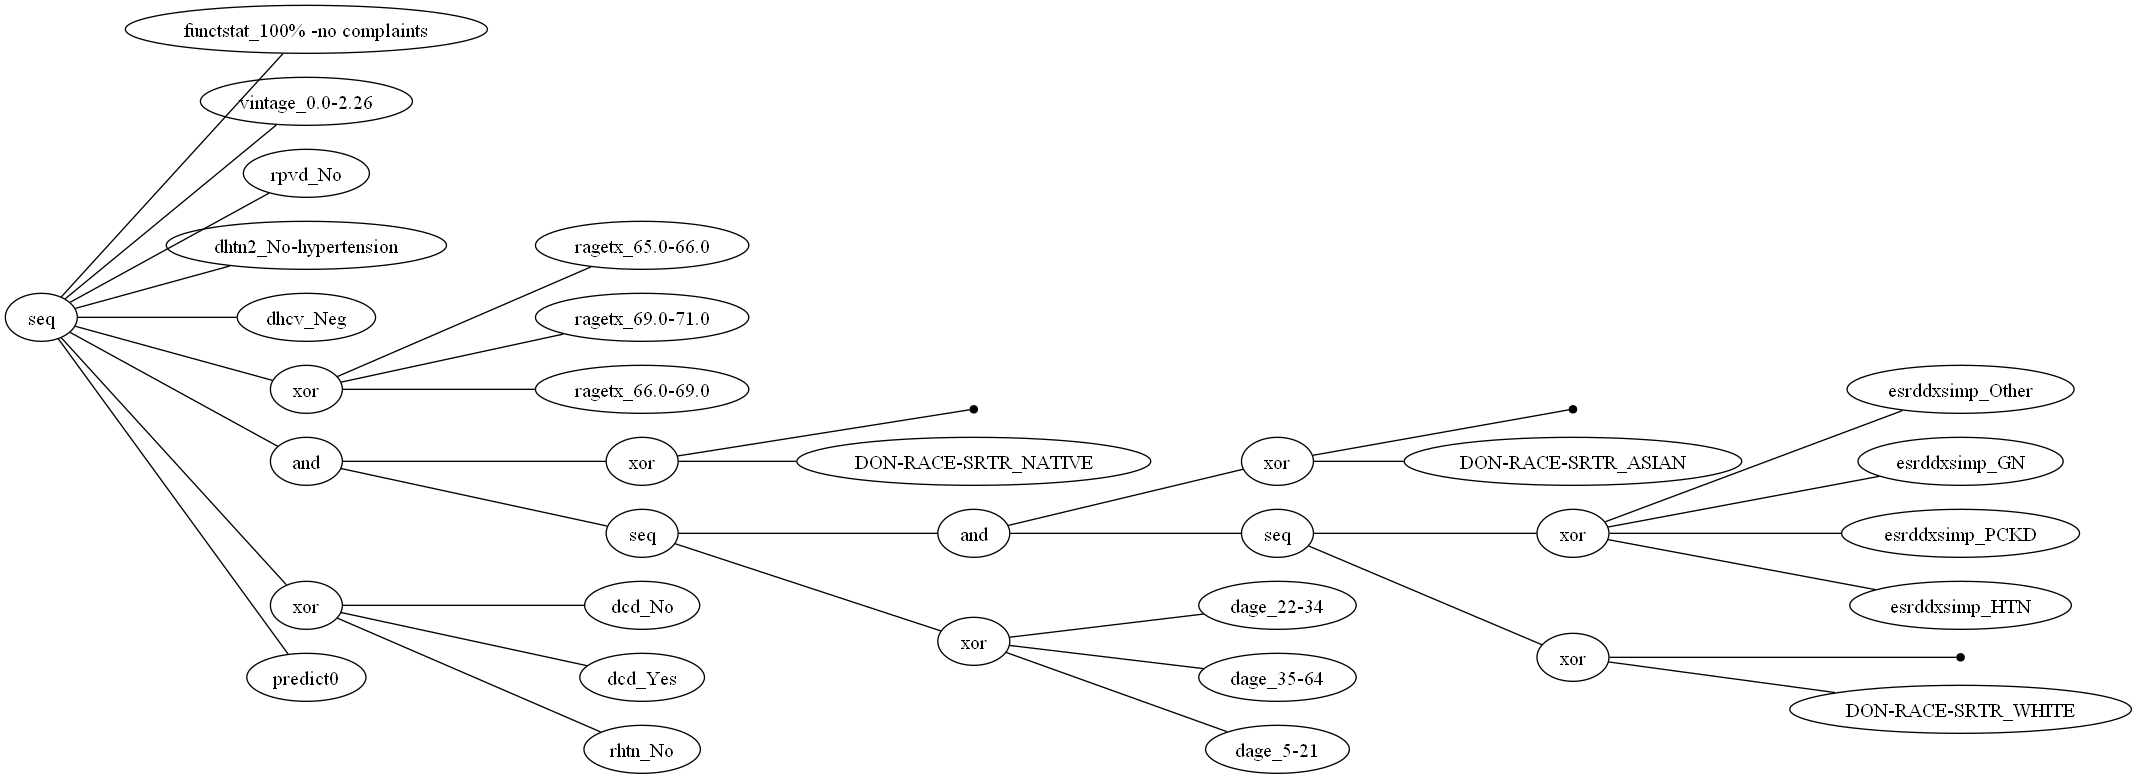

61


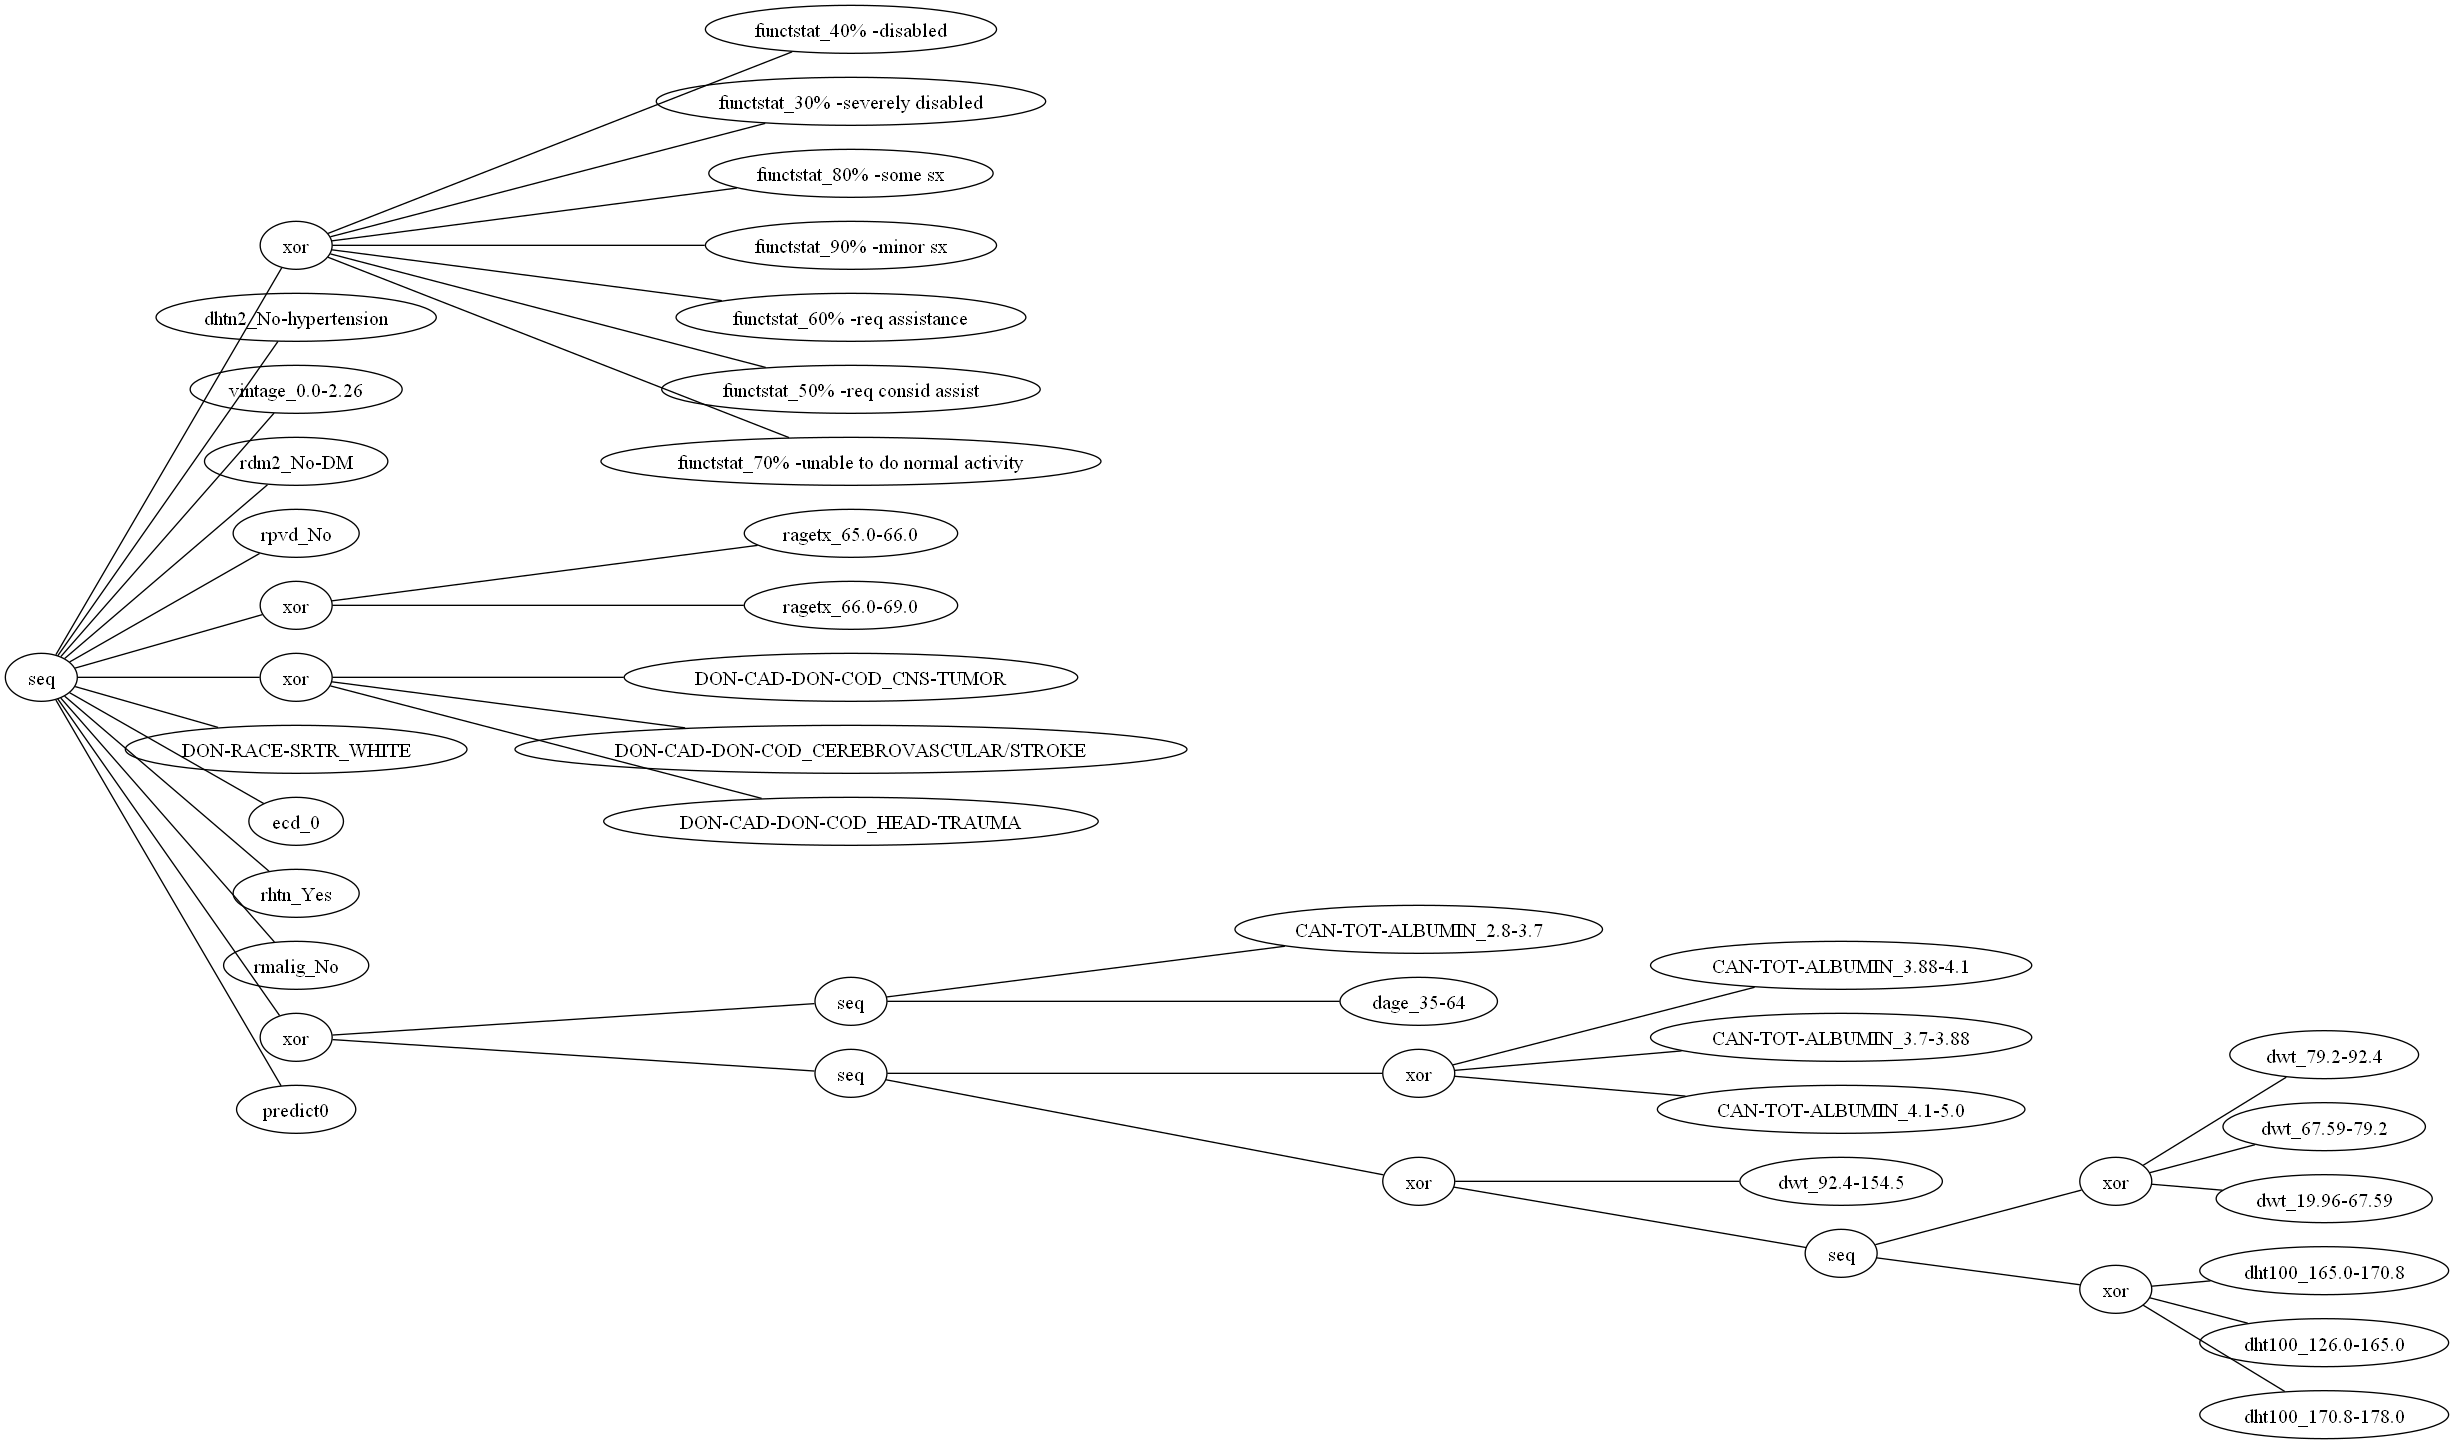

130


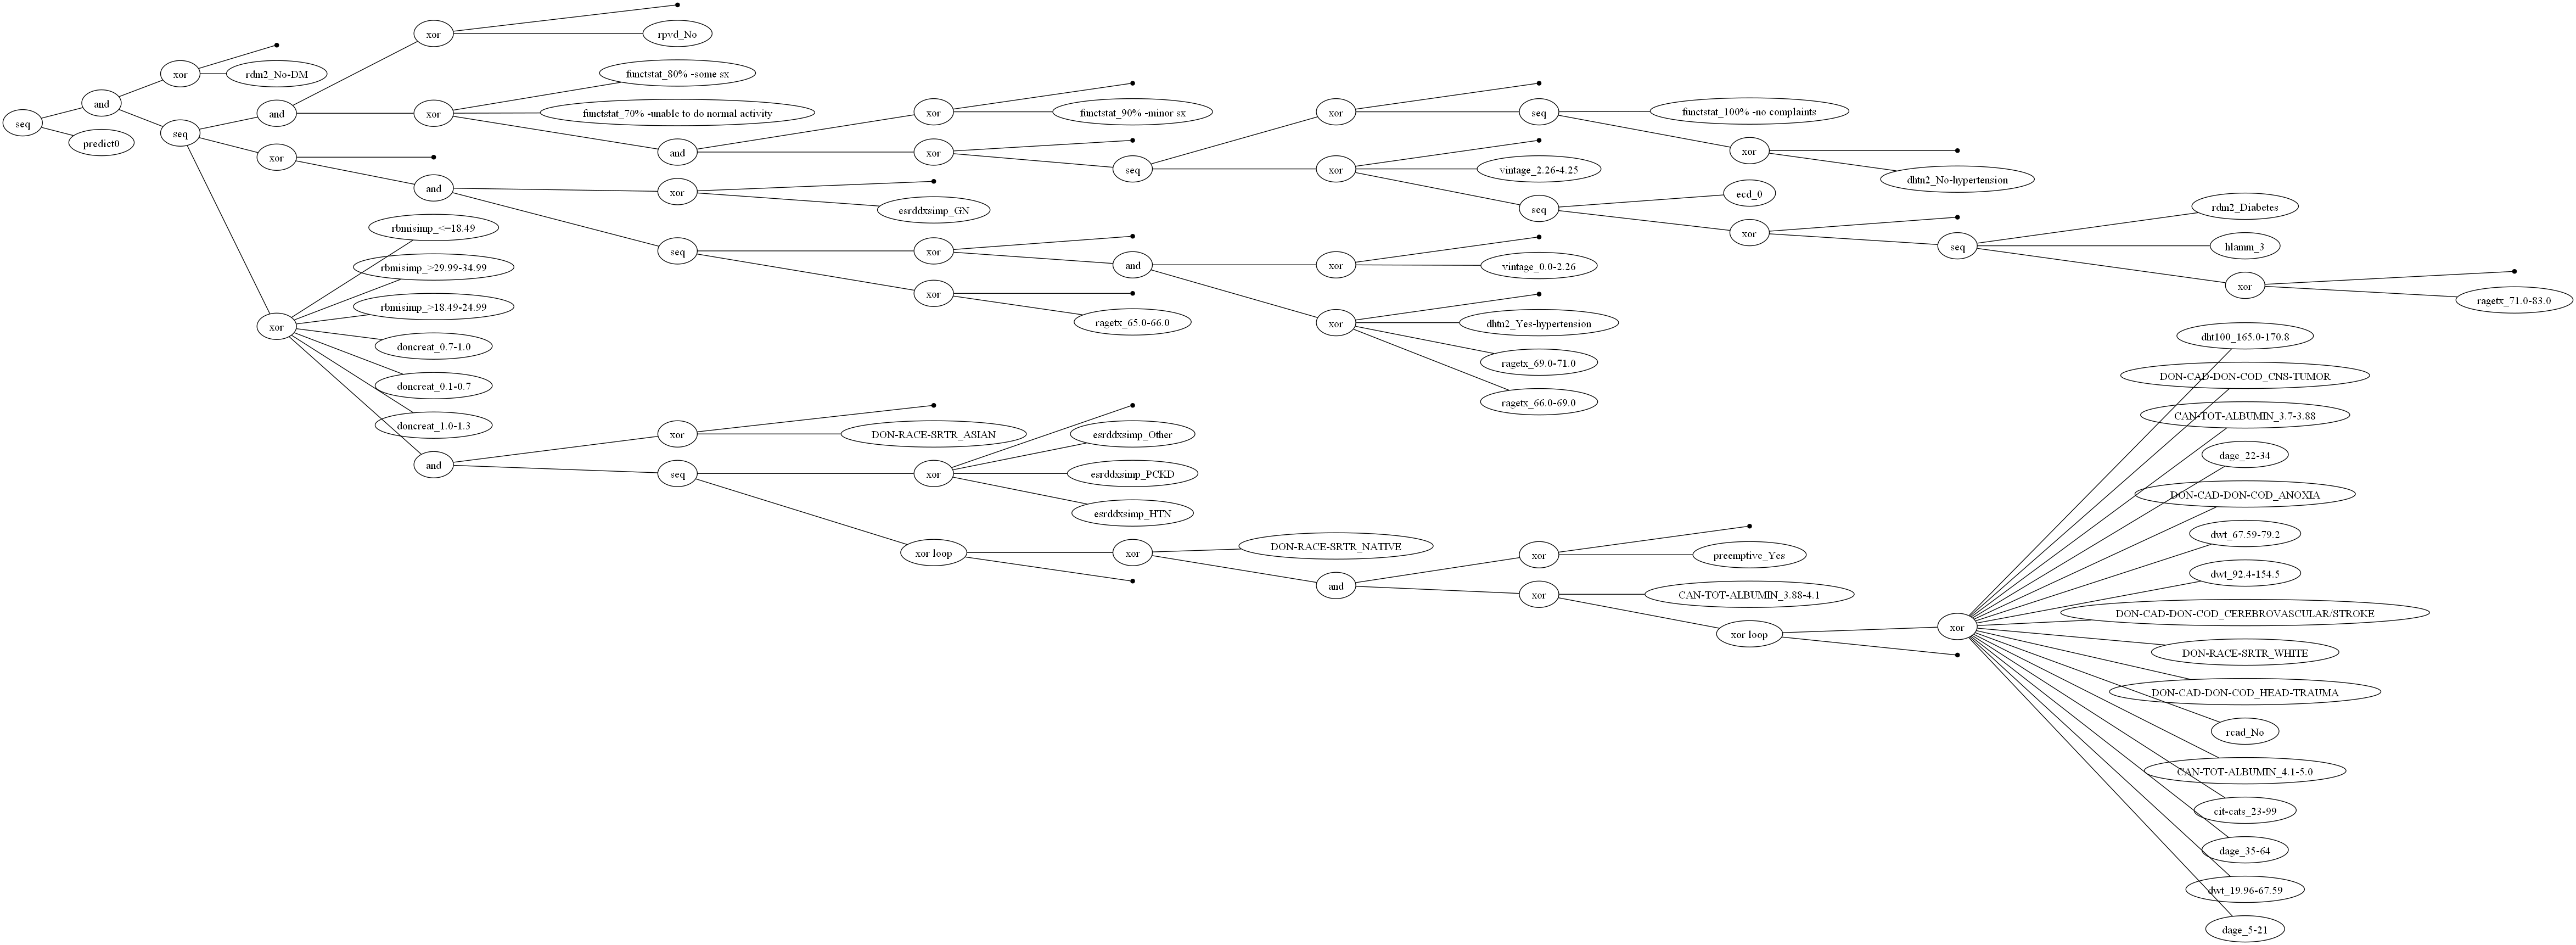

168


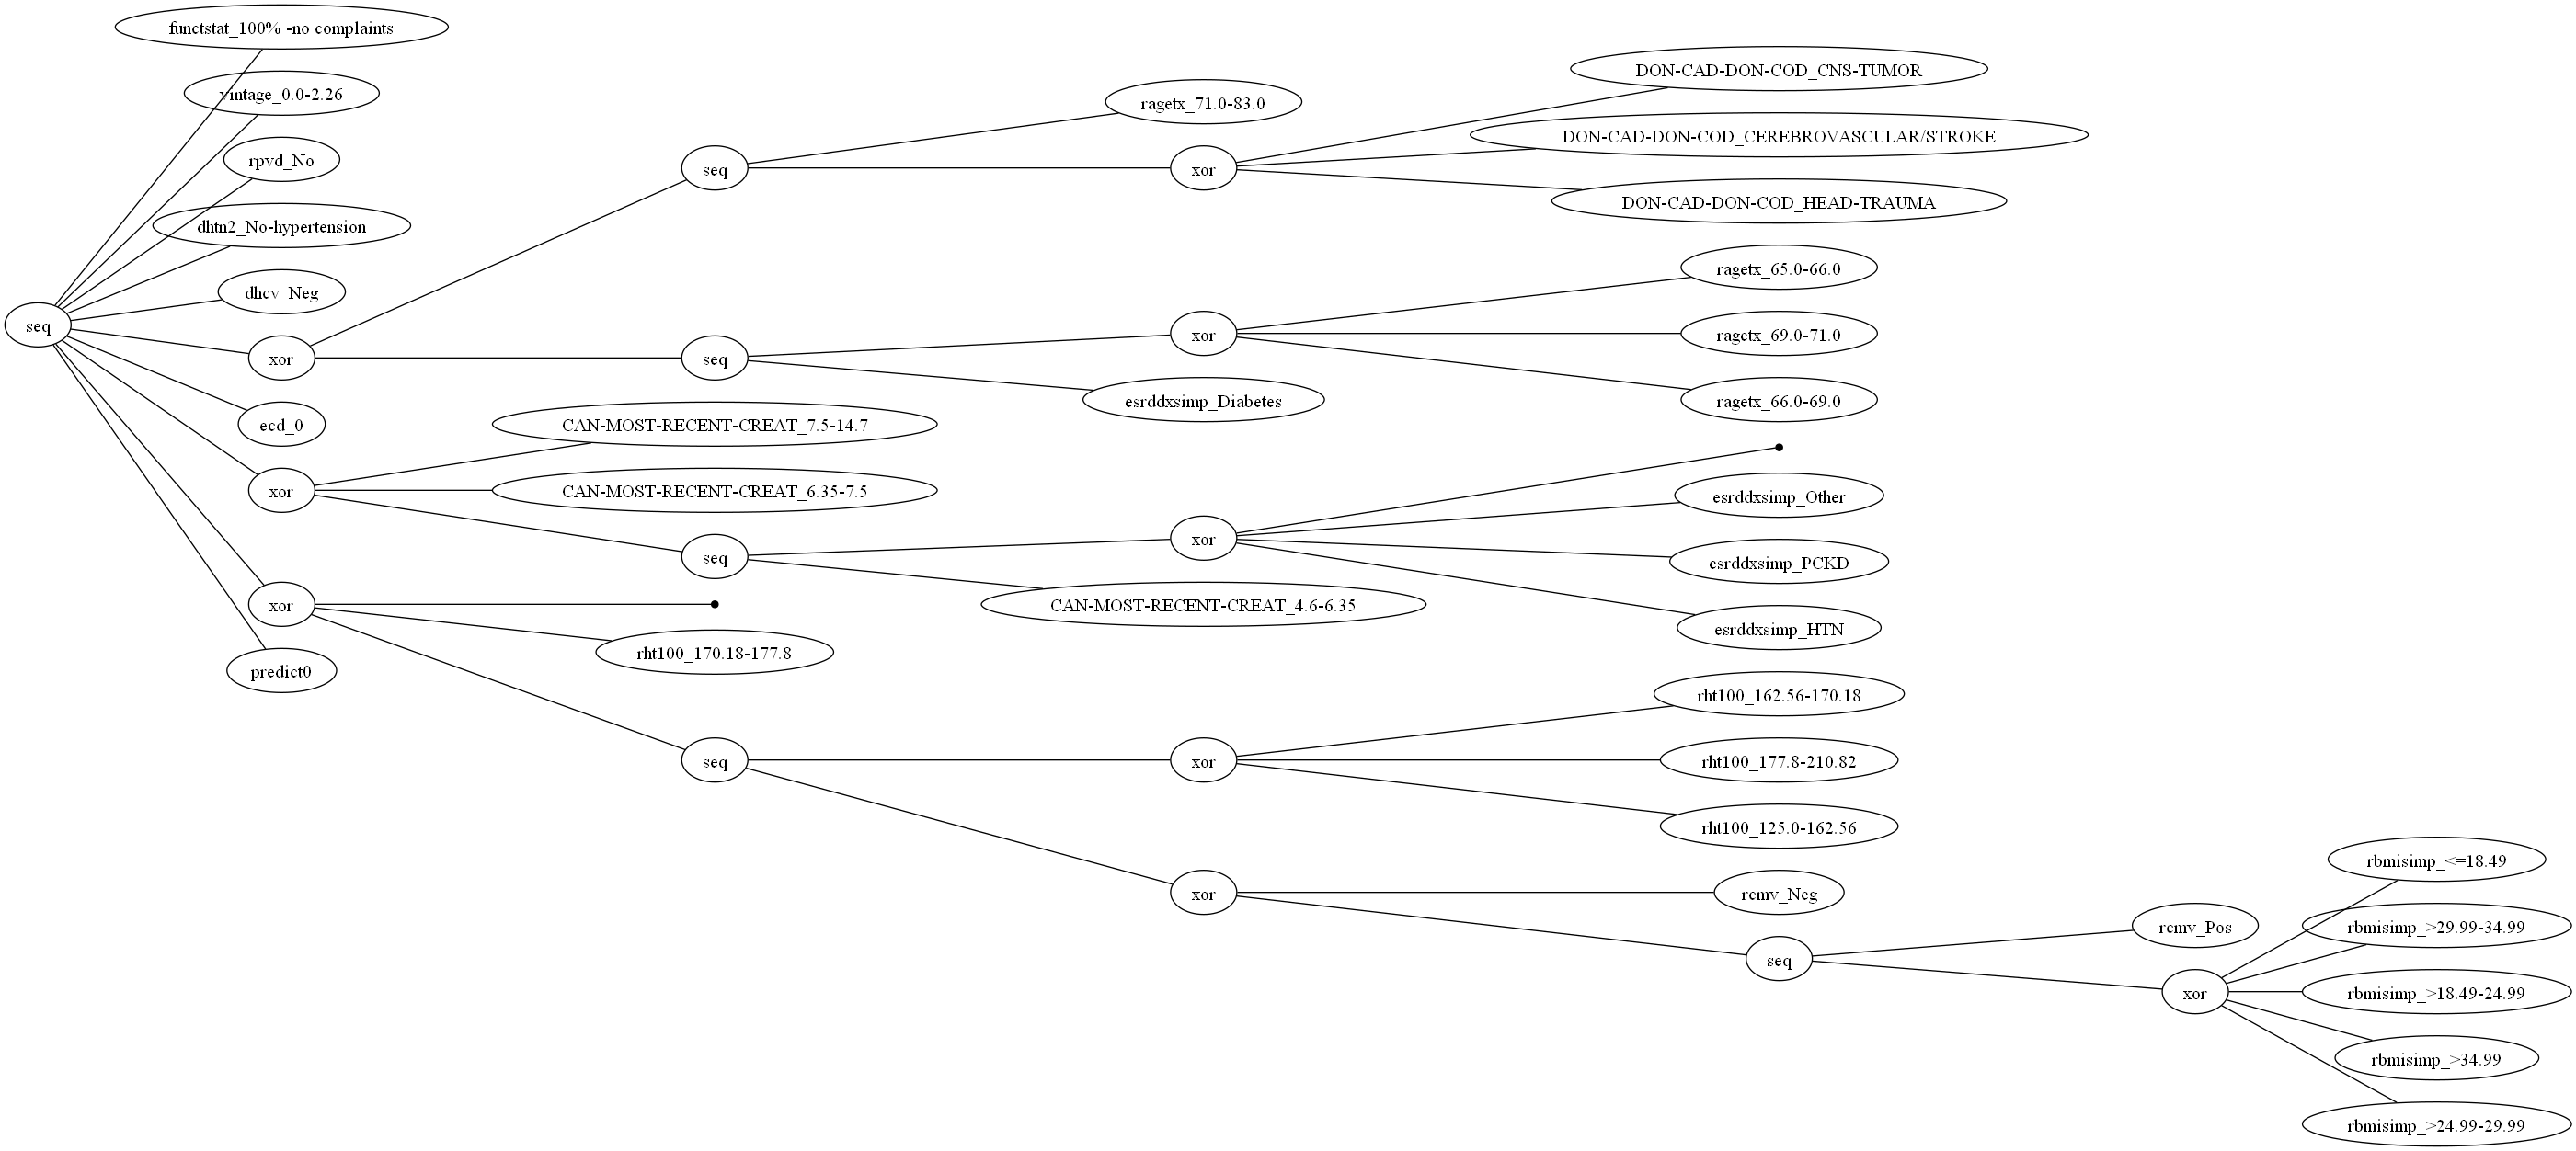

85


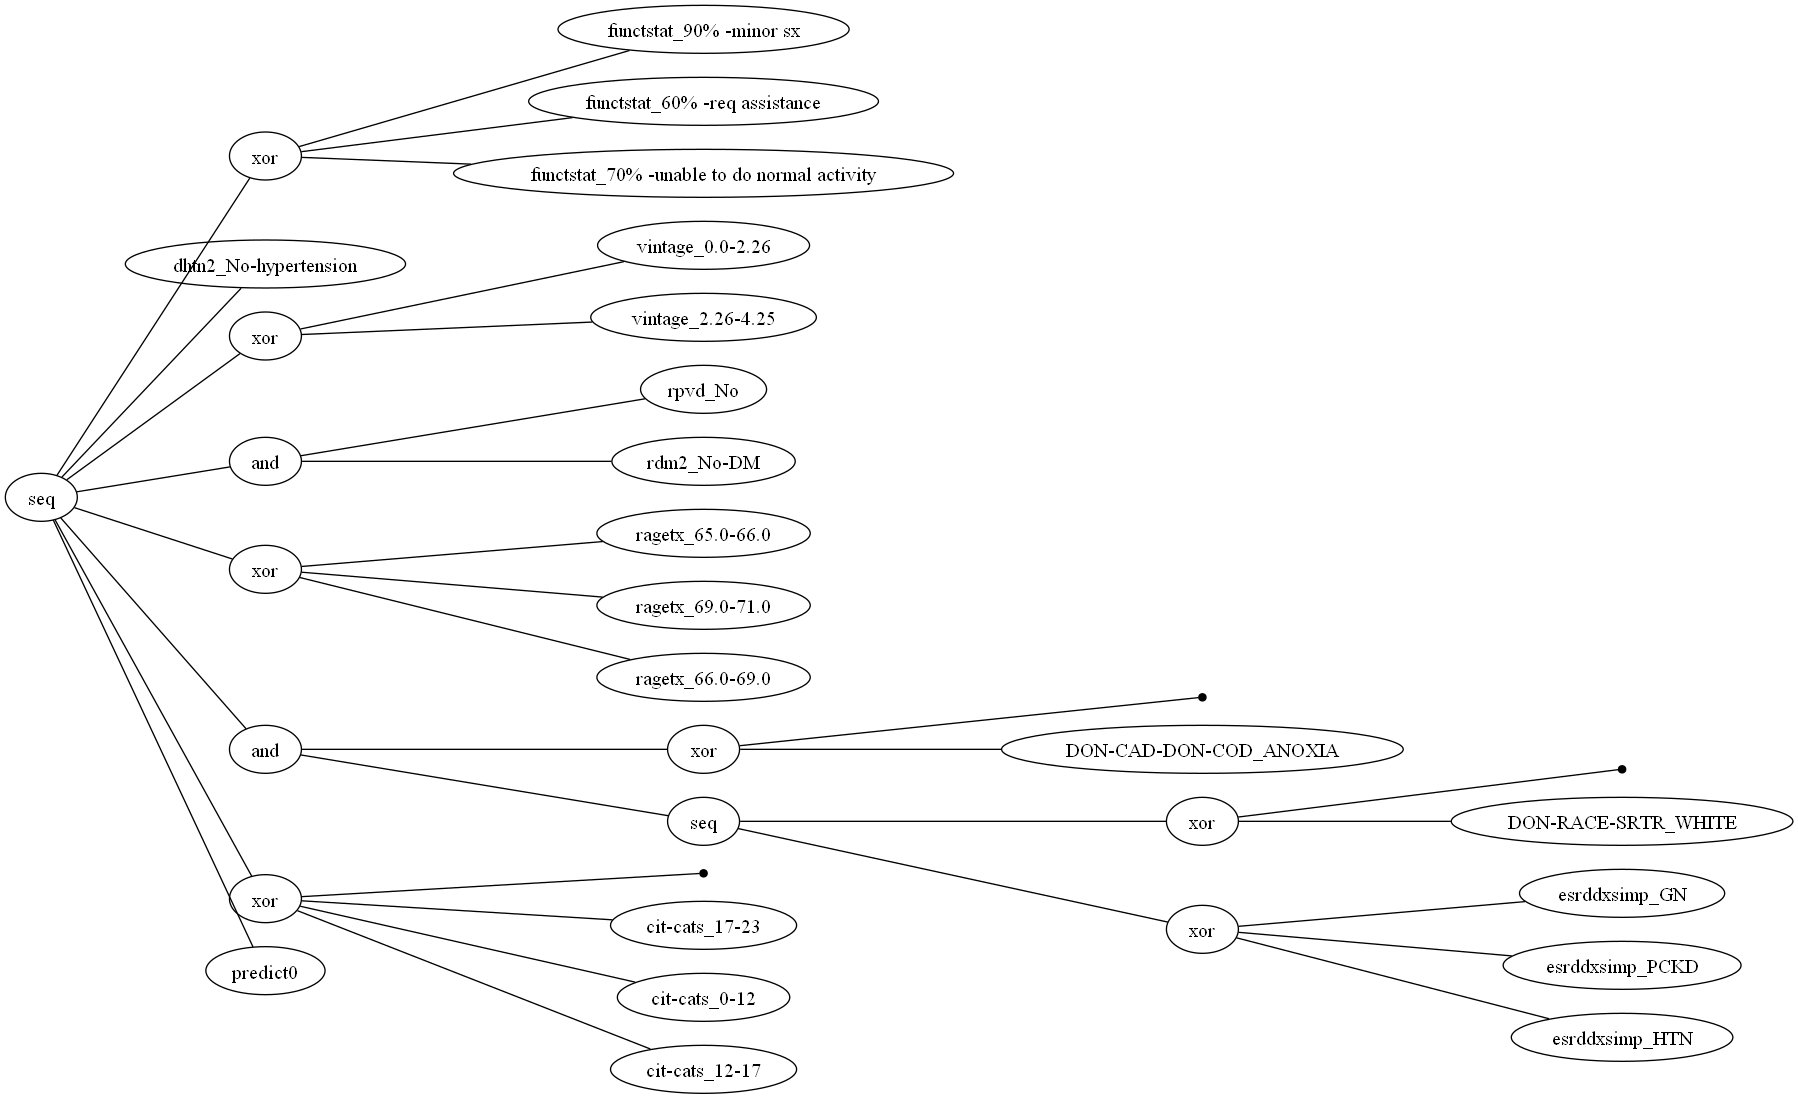

55


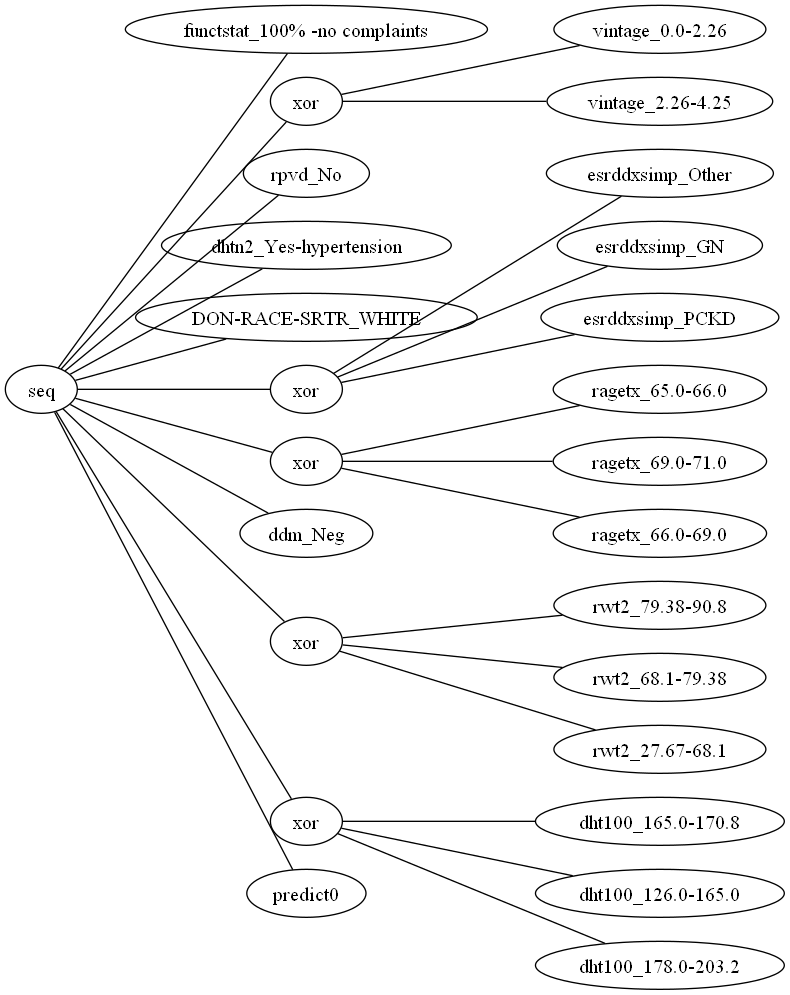

66


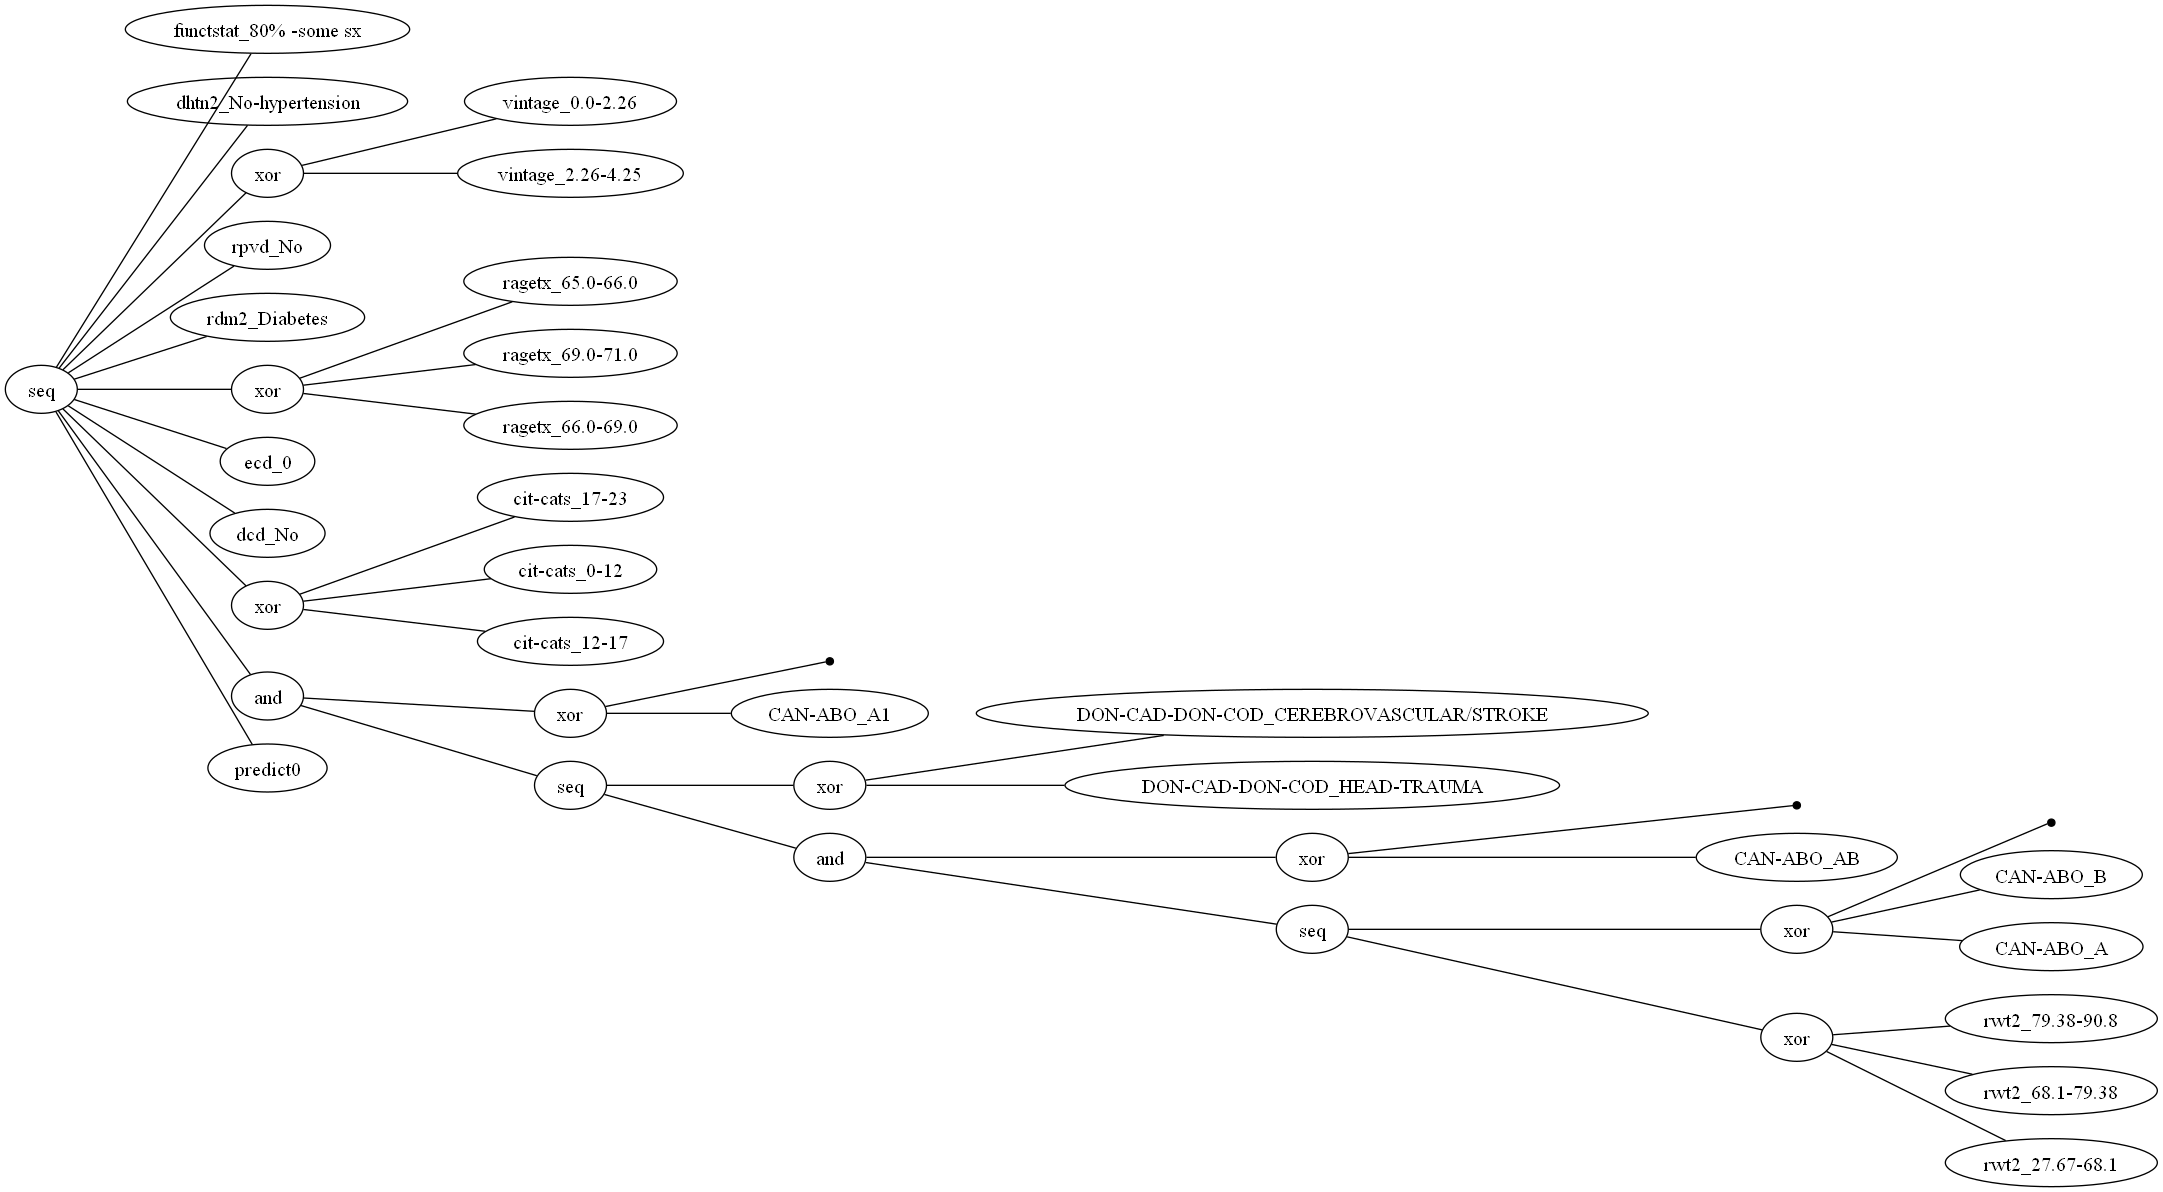

43


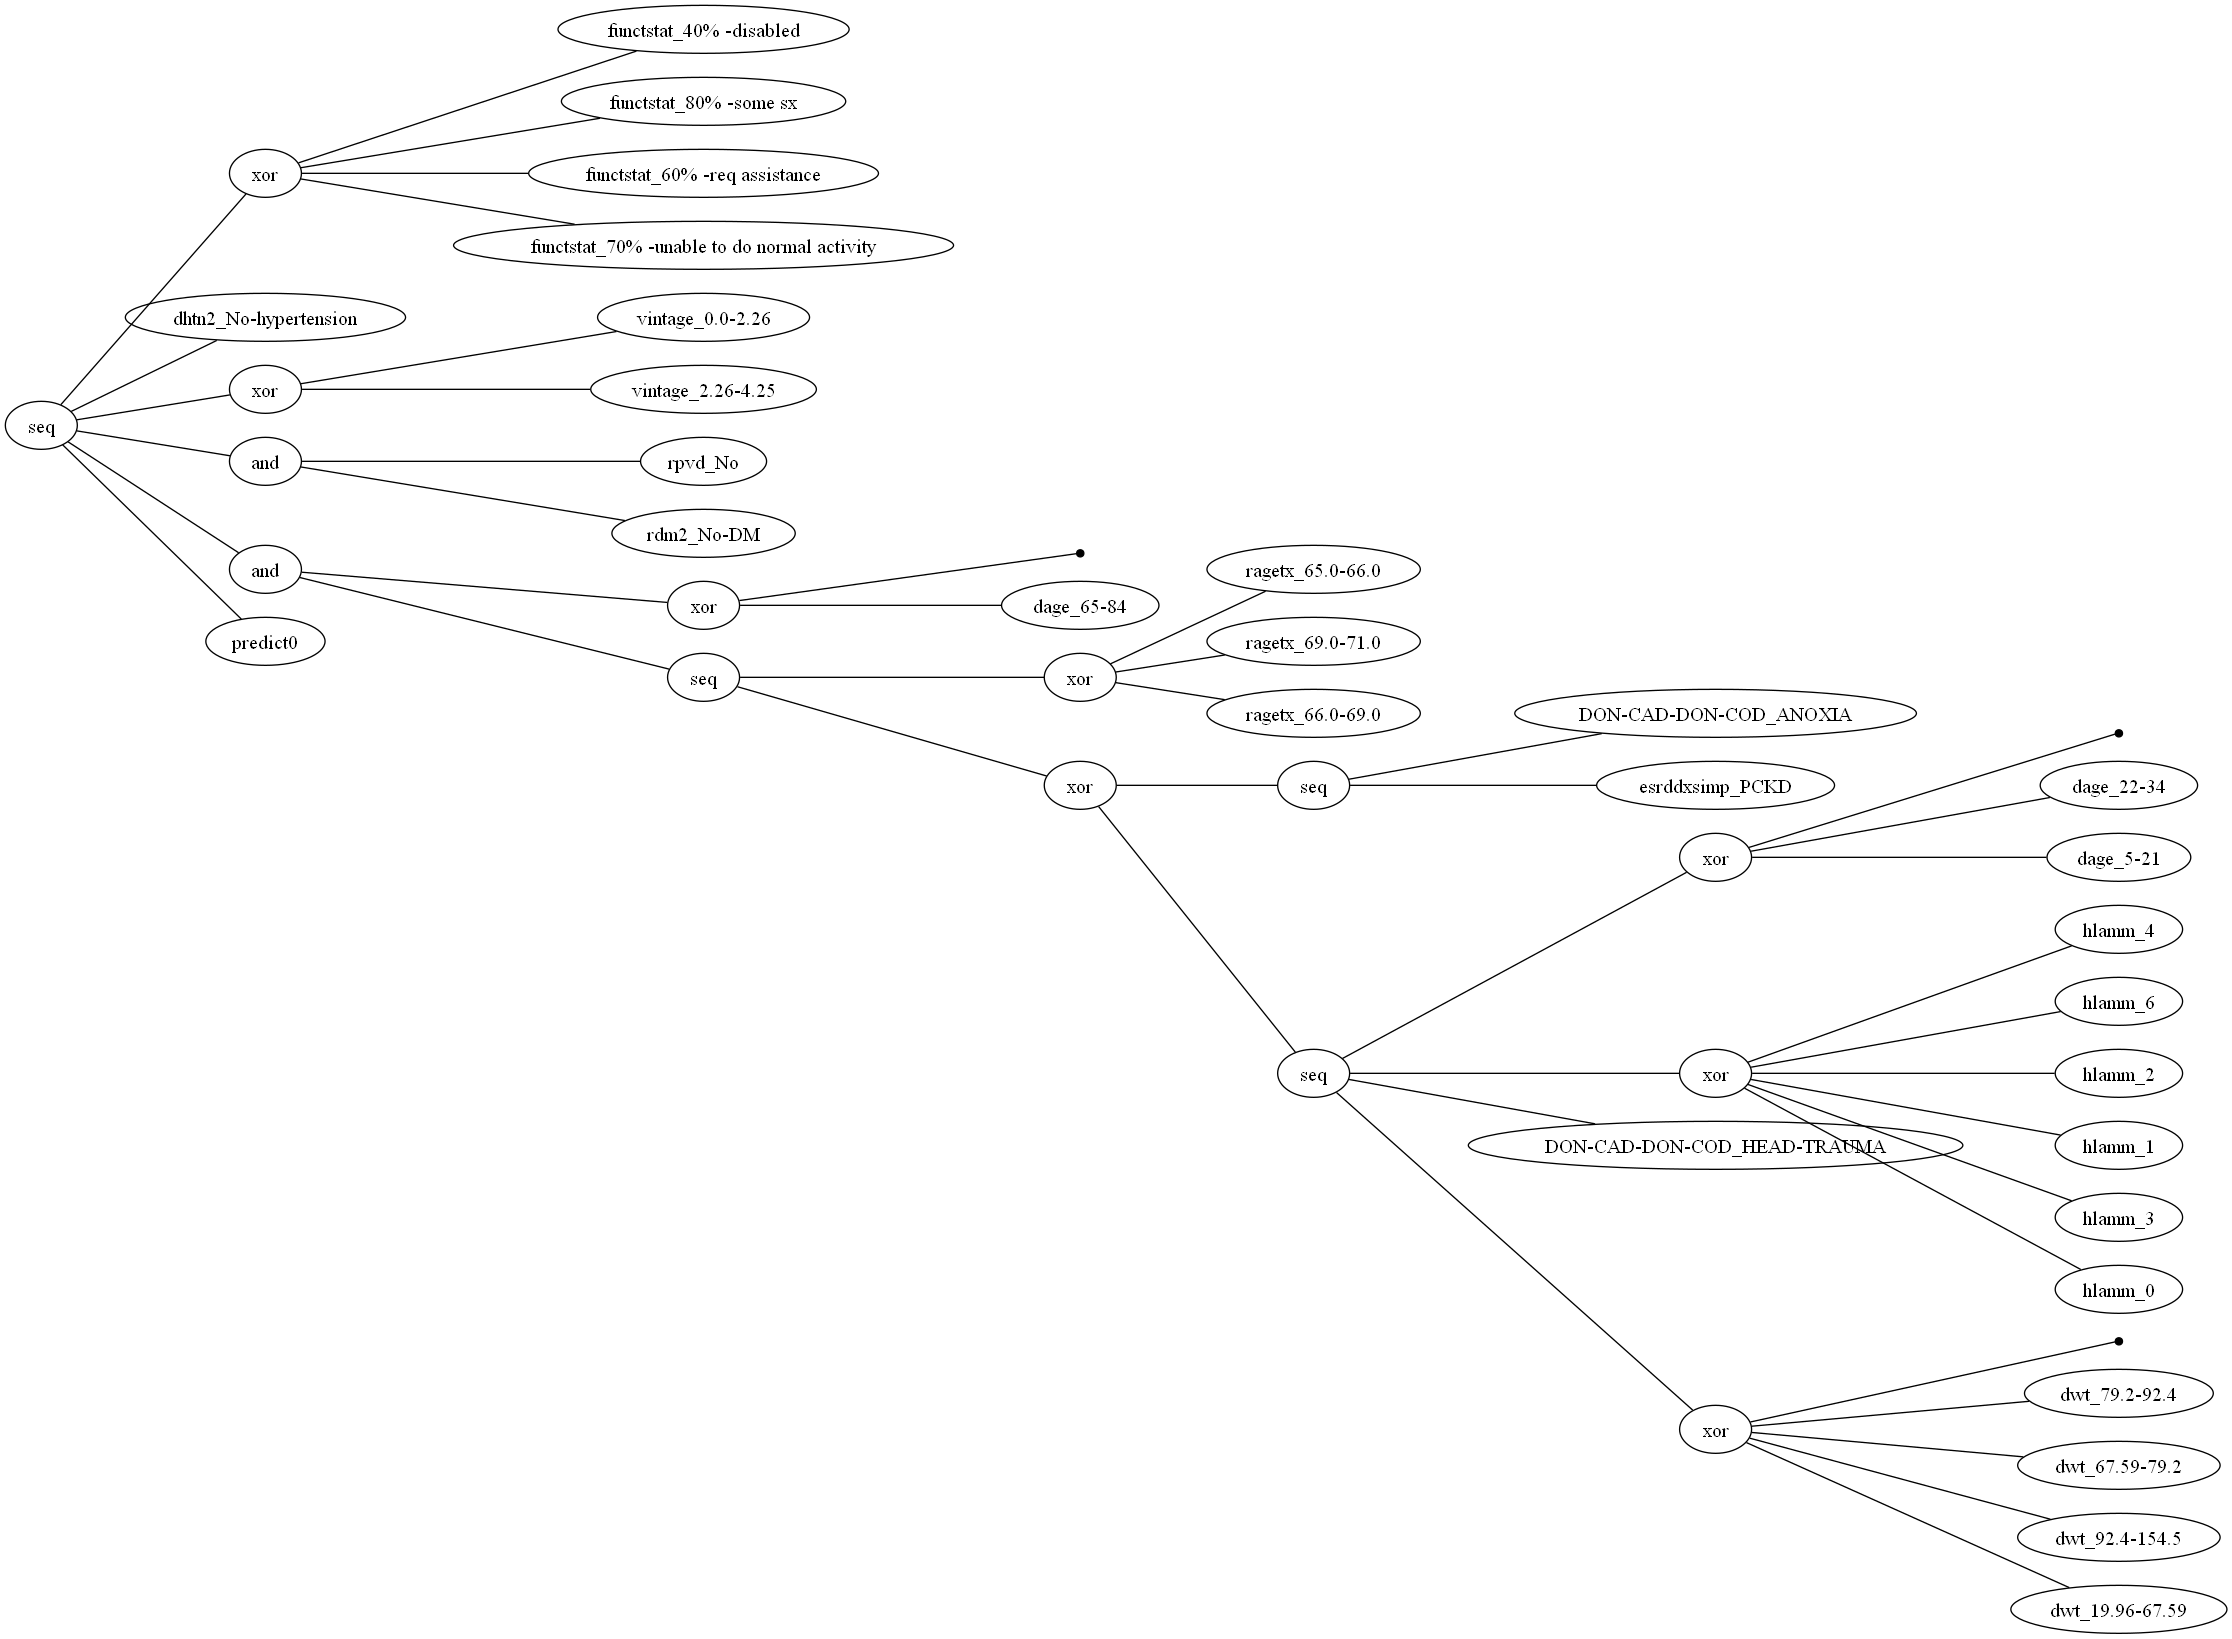

102


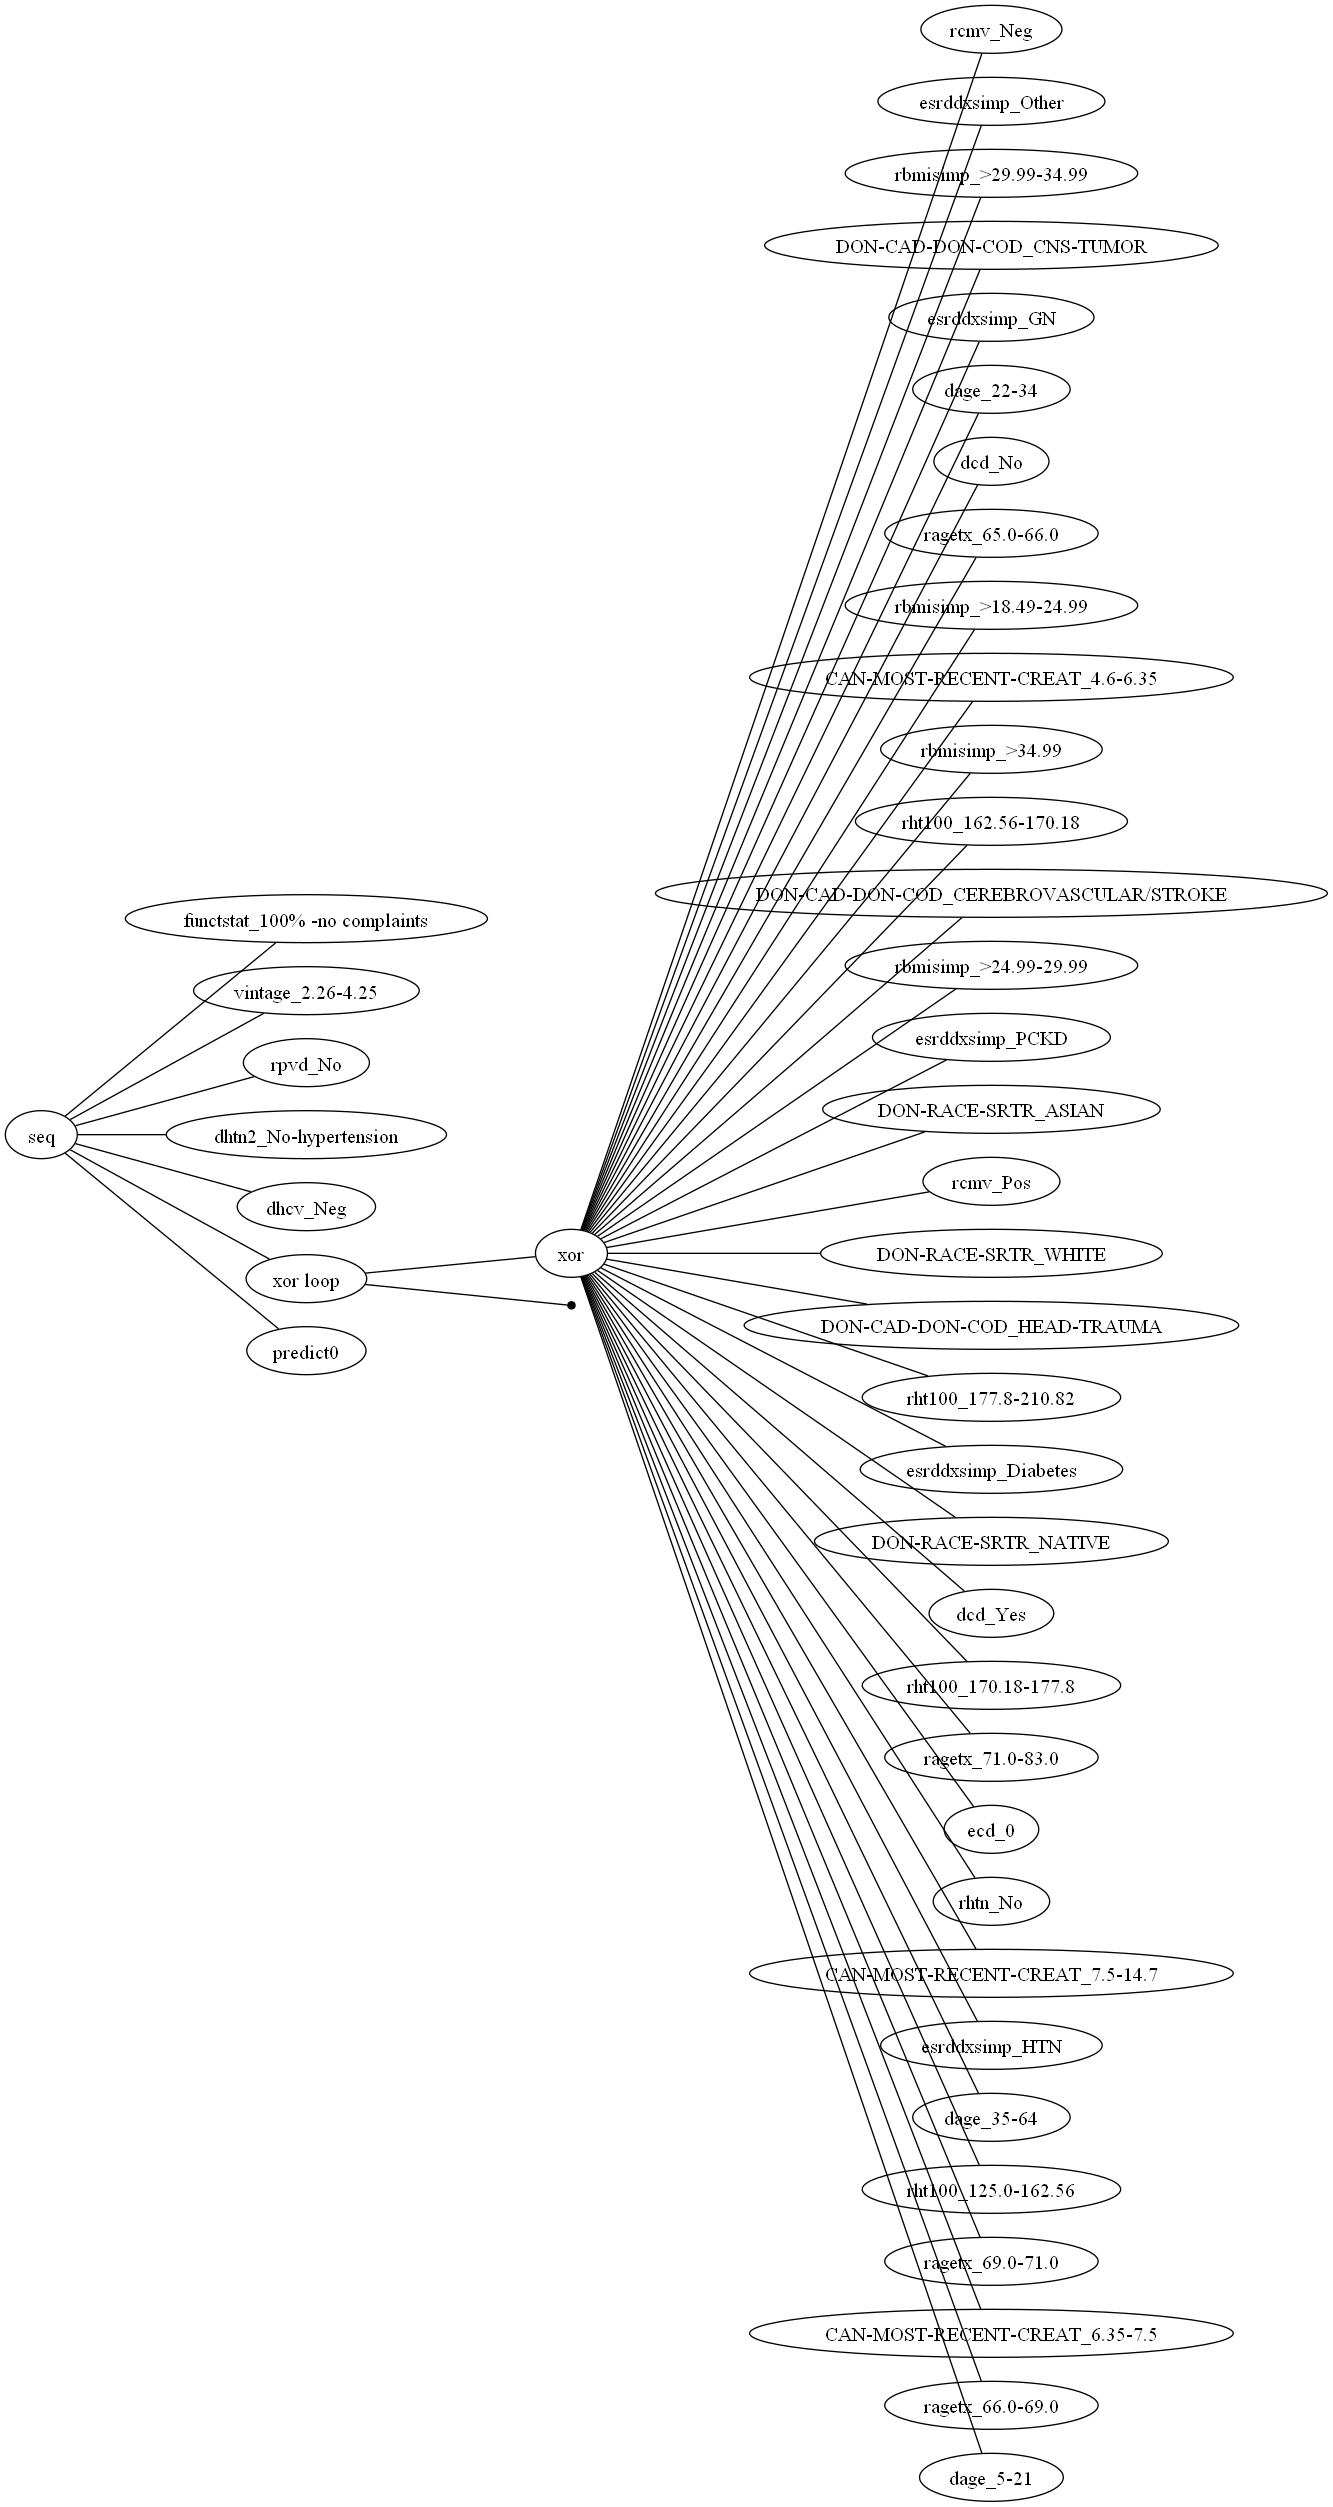

92


In [14]:
cluster_holder = []
clusterer = ml_utils.KMeans(n_clusters=9, random_state=0, n_init="auto")
for clust_log in pm4py.cluster_log(log0, sklearn_clusterer=clusterer):
    cluster_holder.append(clust_log)
    process_tree = pm4py.discover_process_tree_inductive(clust_log)

    if importlib.util.find_spec("graphviz"):
        pm4py.view_process_tree(process_tree)
        print(len(clust_log))

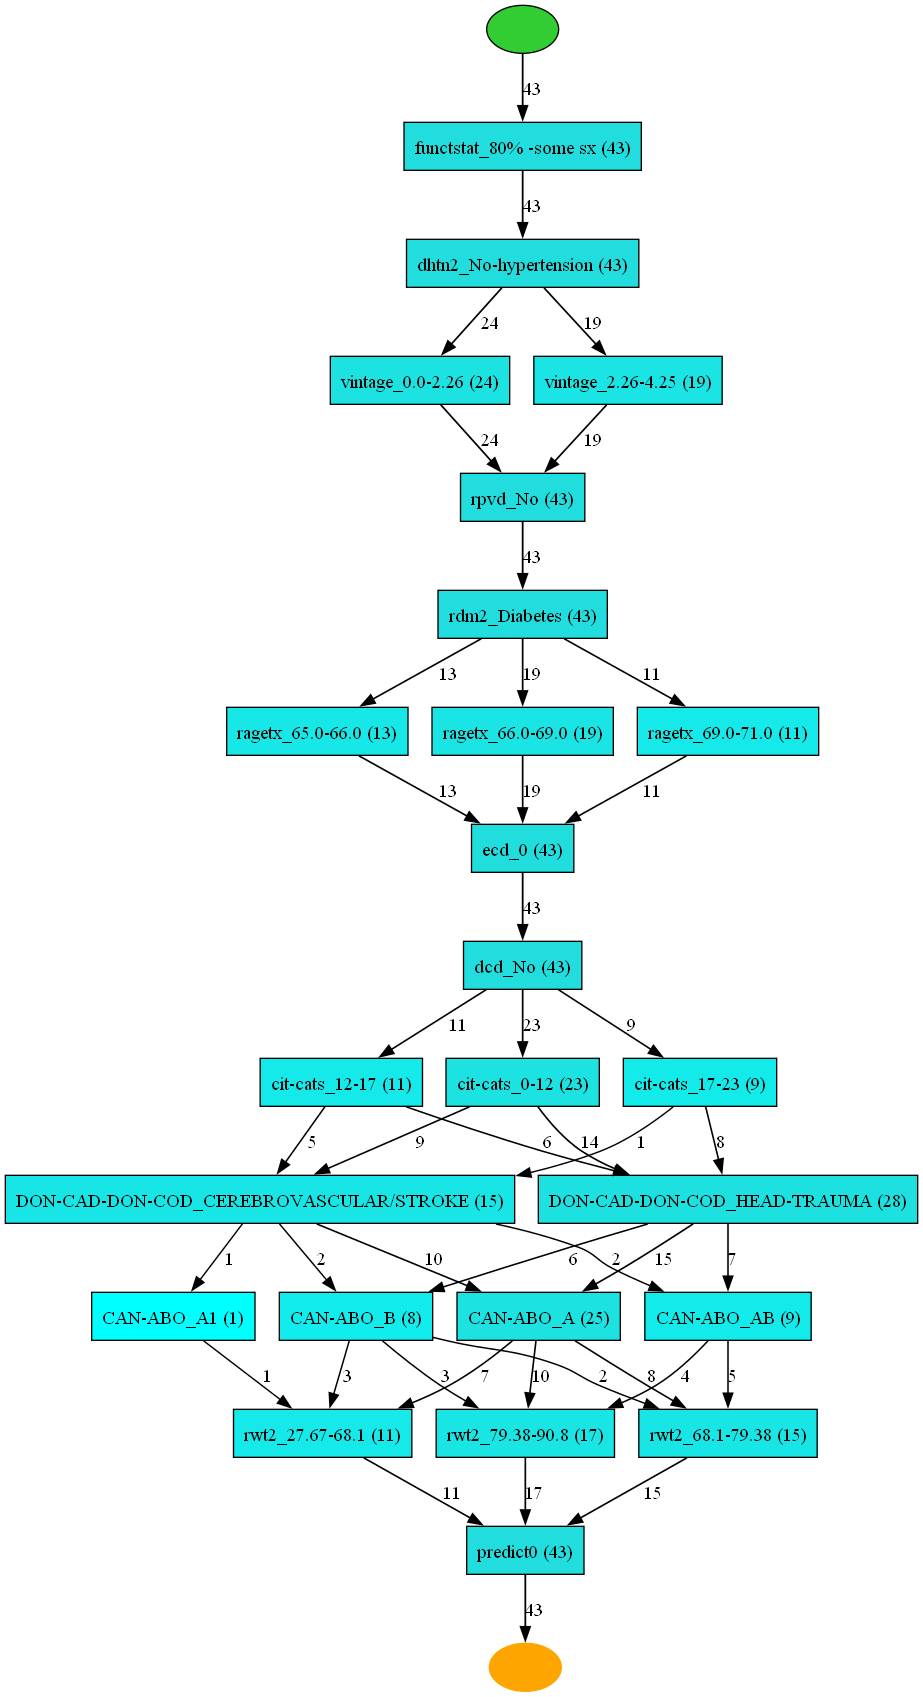

In [15]:
heu_net = heuristics_miner.apply_heu(cluster_holder[6])

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

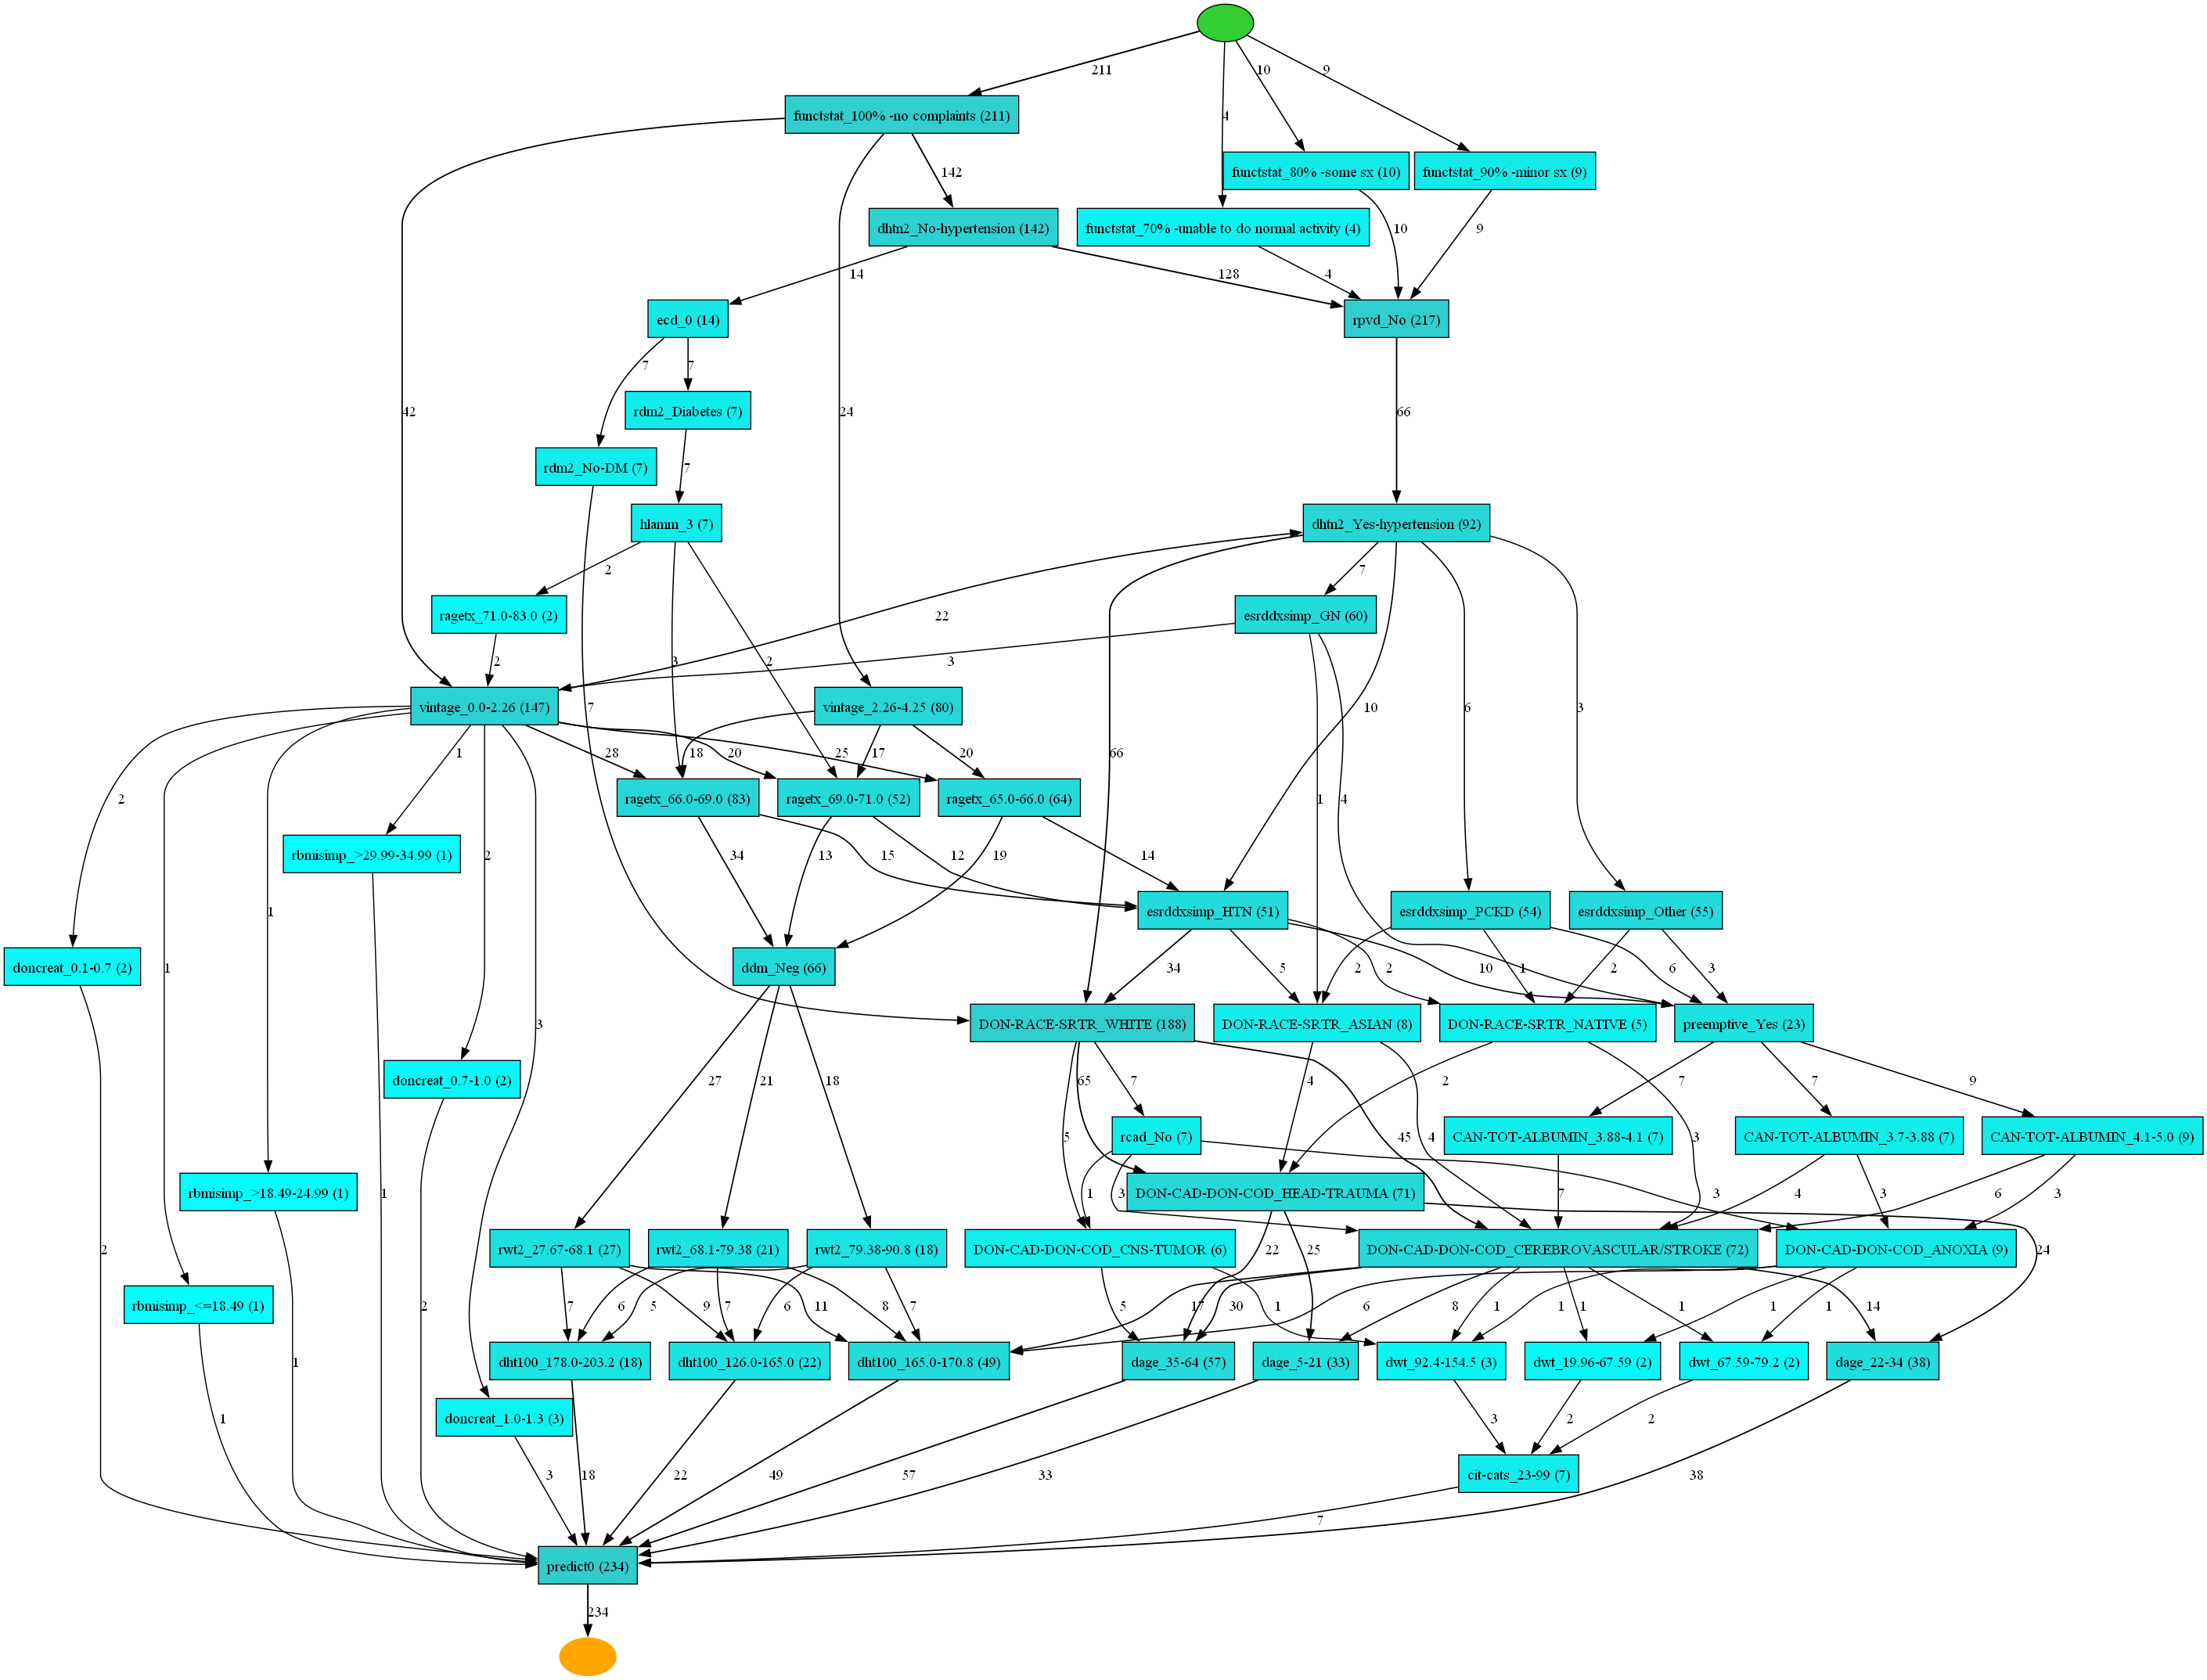

In [52]:
heu_net = heuristics_miner.apply_heu(cluster_holder[1])

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

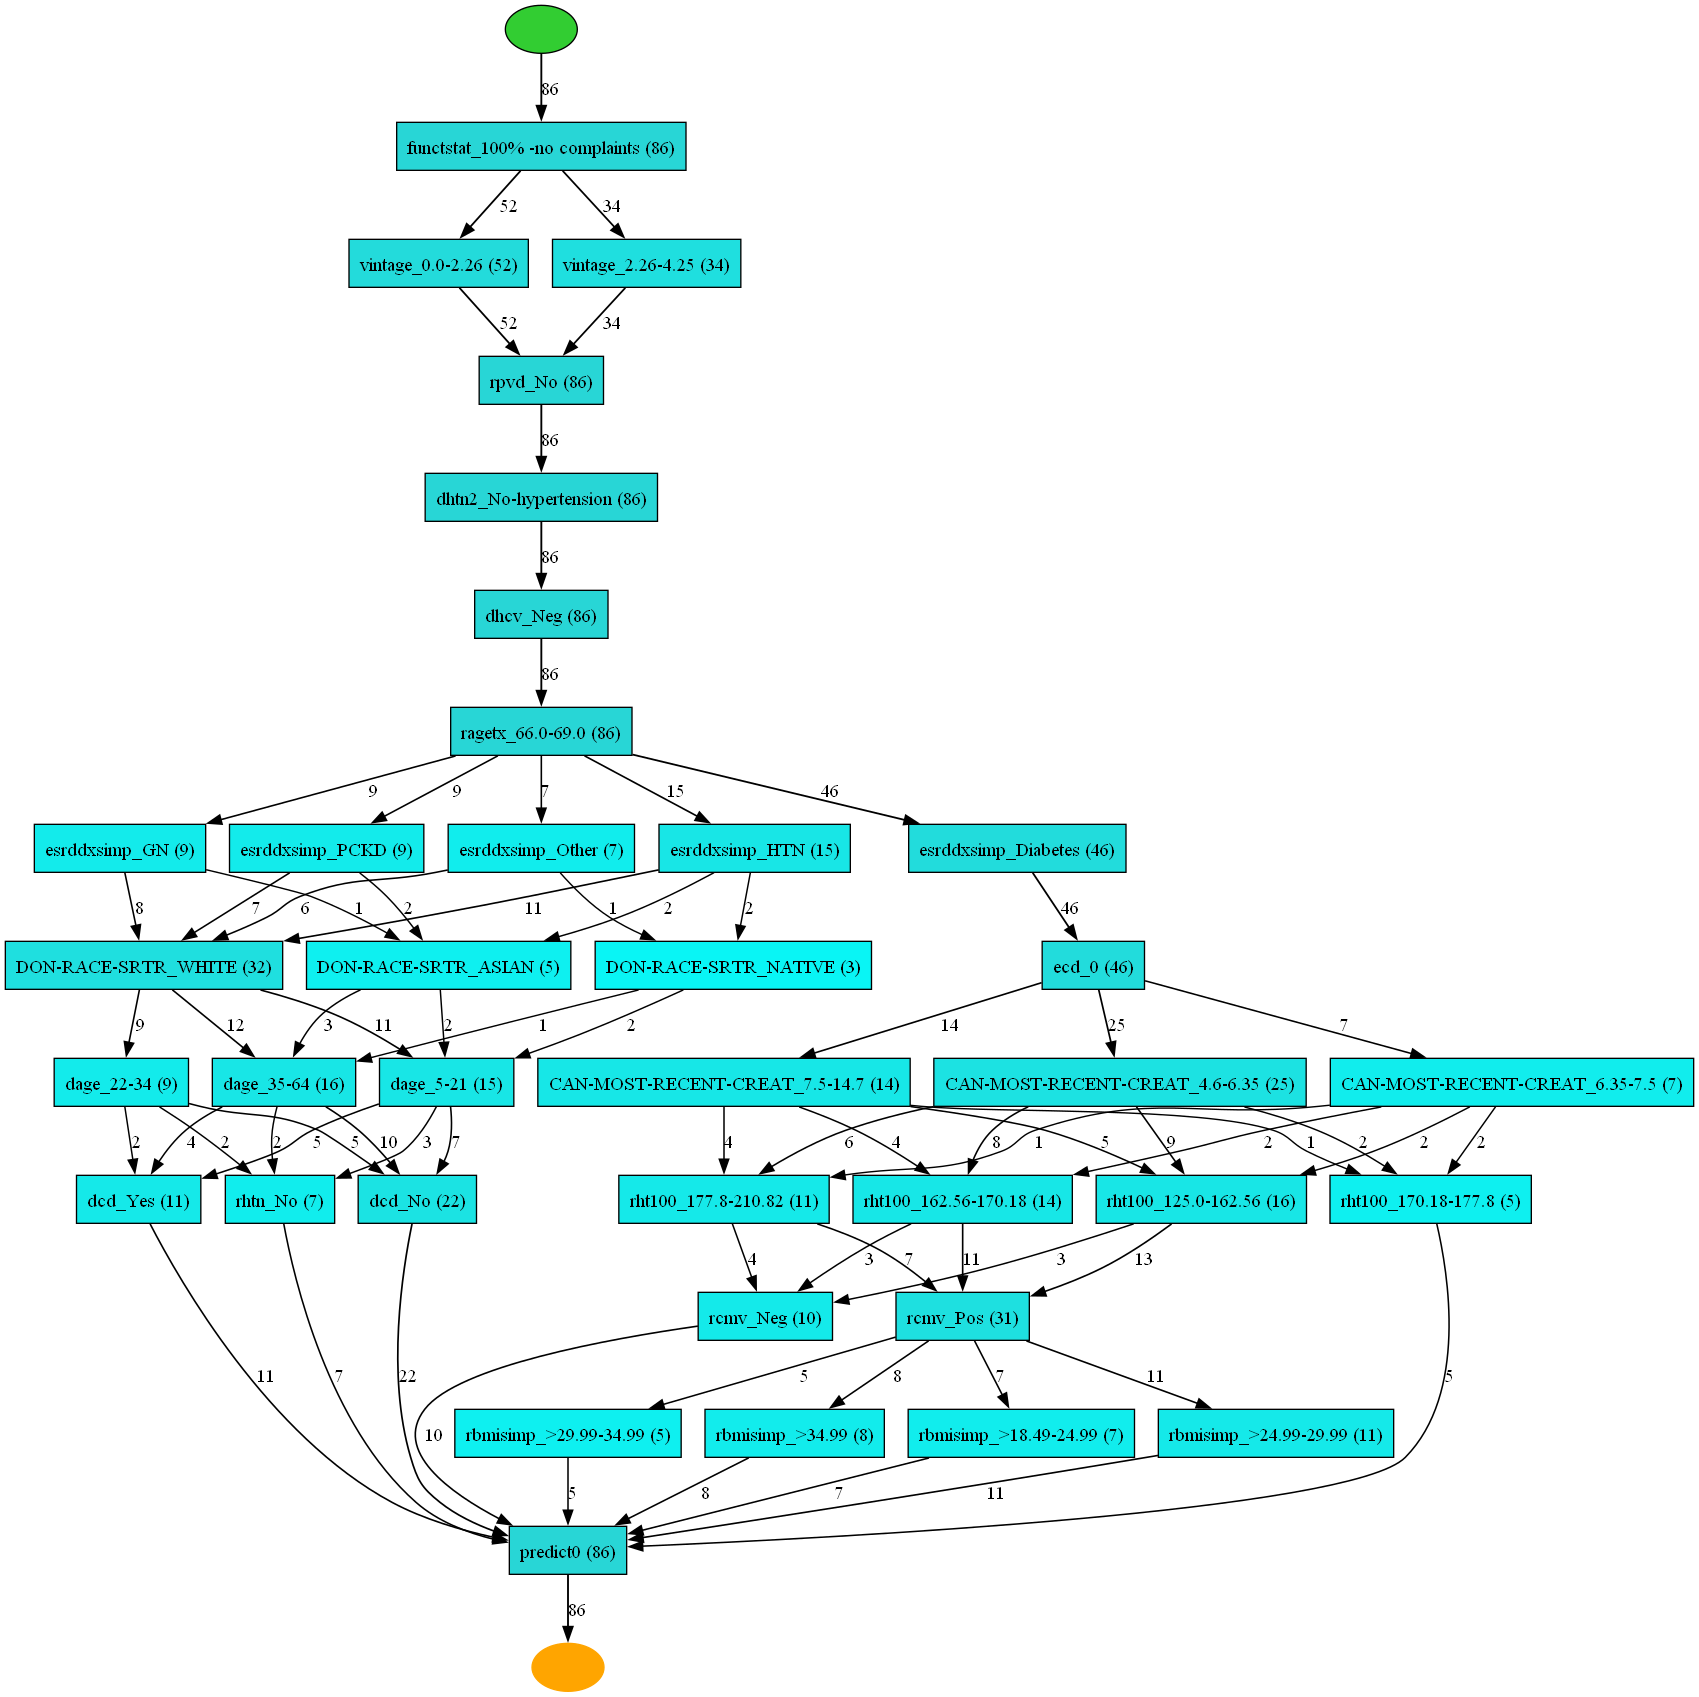

In [50]:
heu_net = heuristics_miner.apply_heu(cluster_holder[0])

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

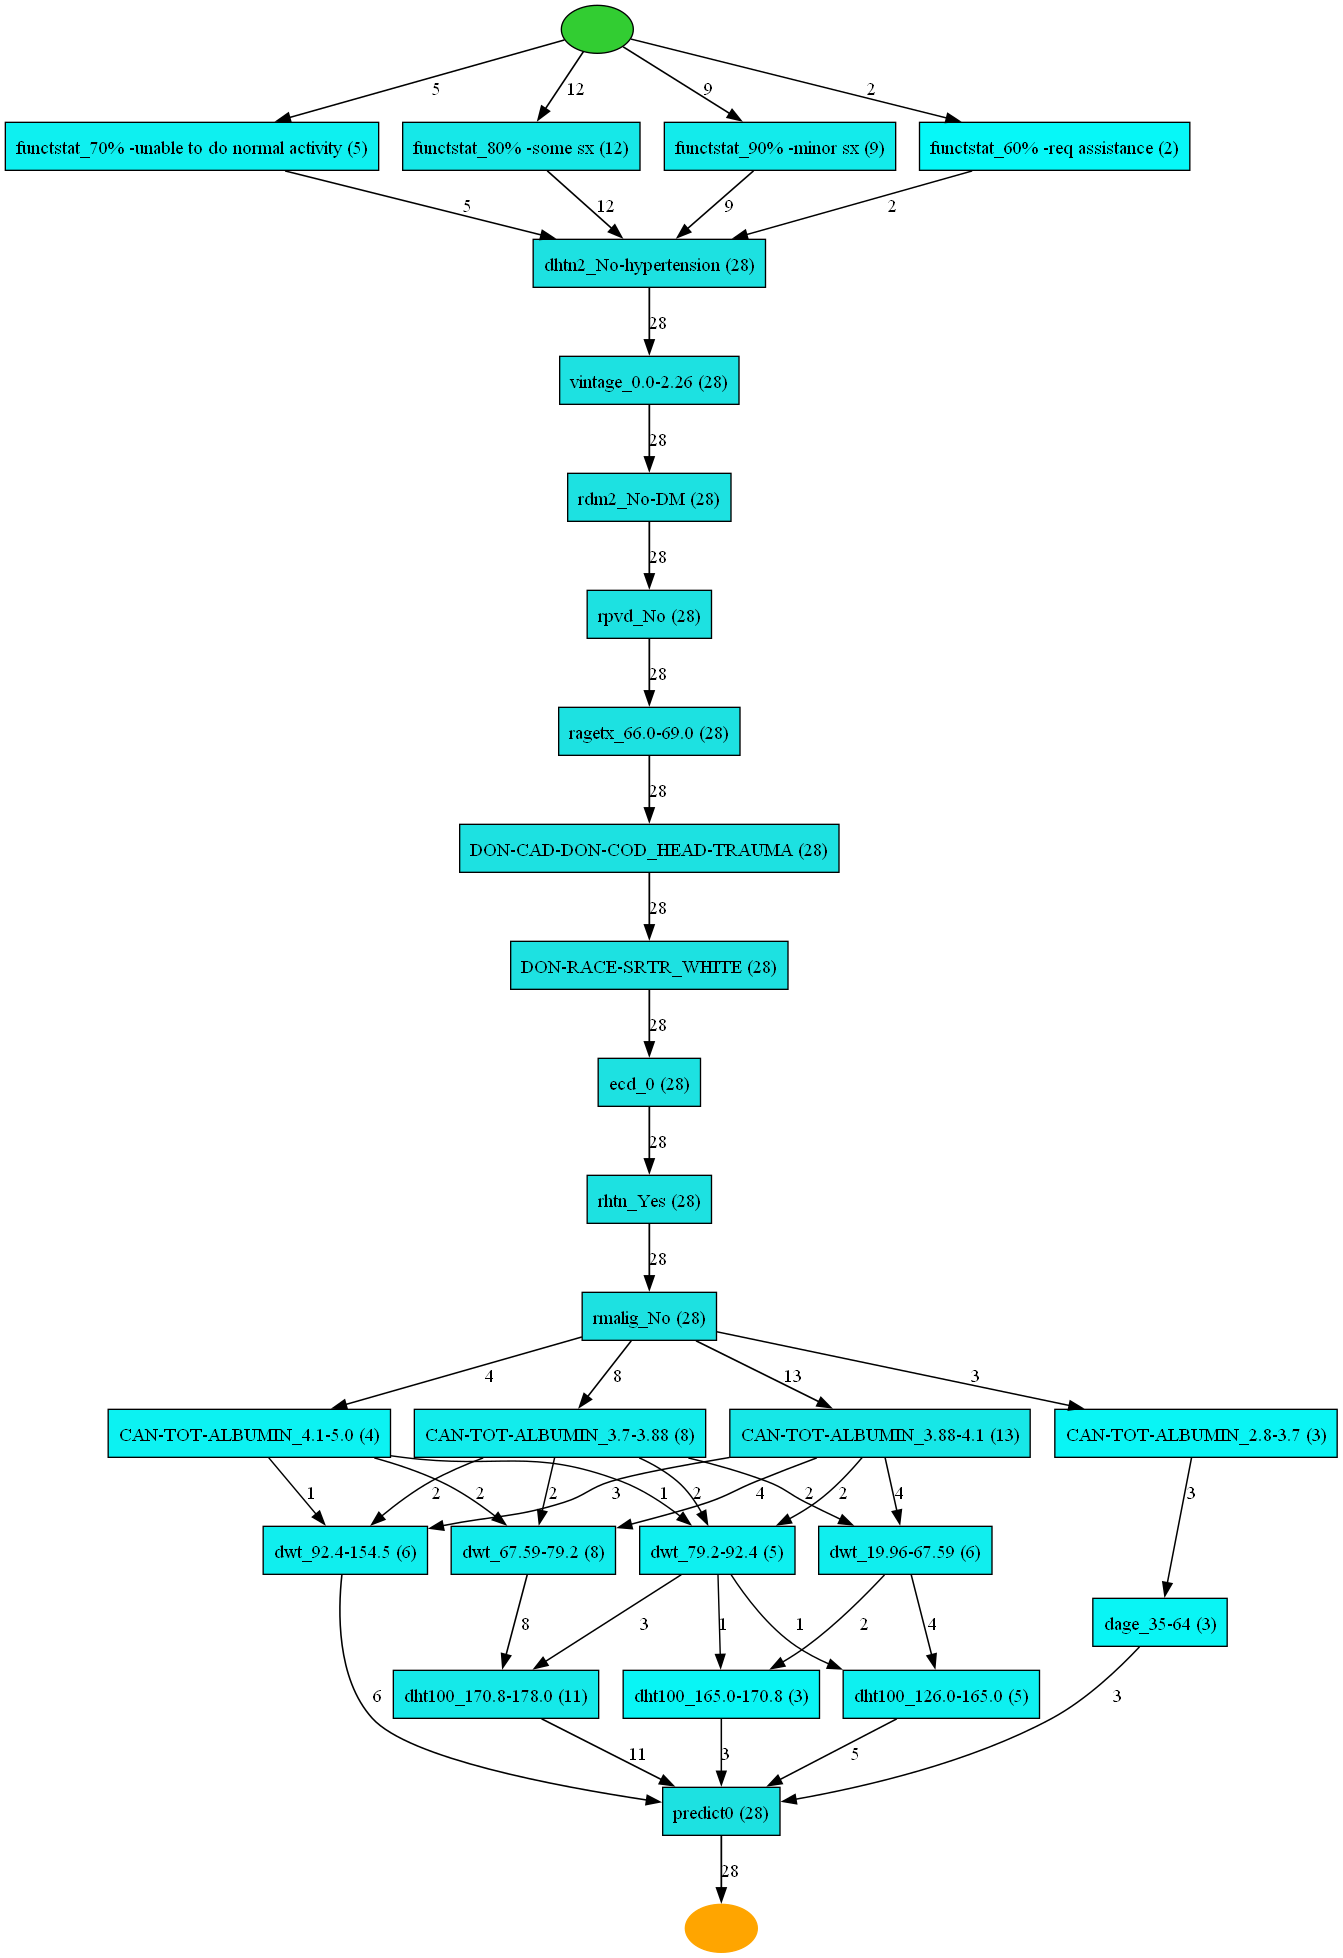

In [38]:
heu_net = heuristics_miner.apply_heu(cluster_holder[1])

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

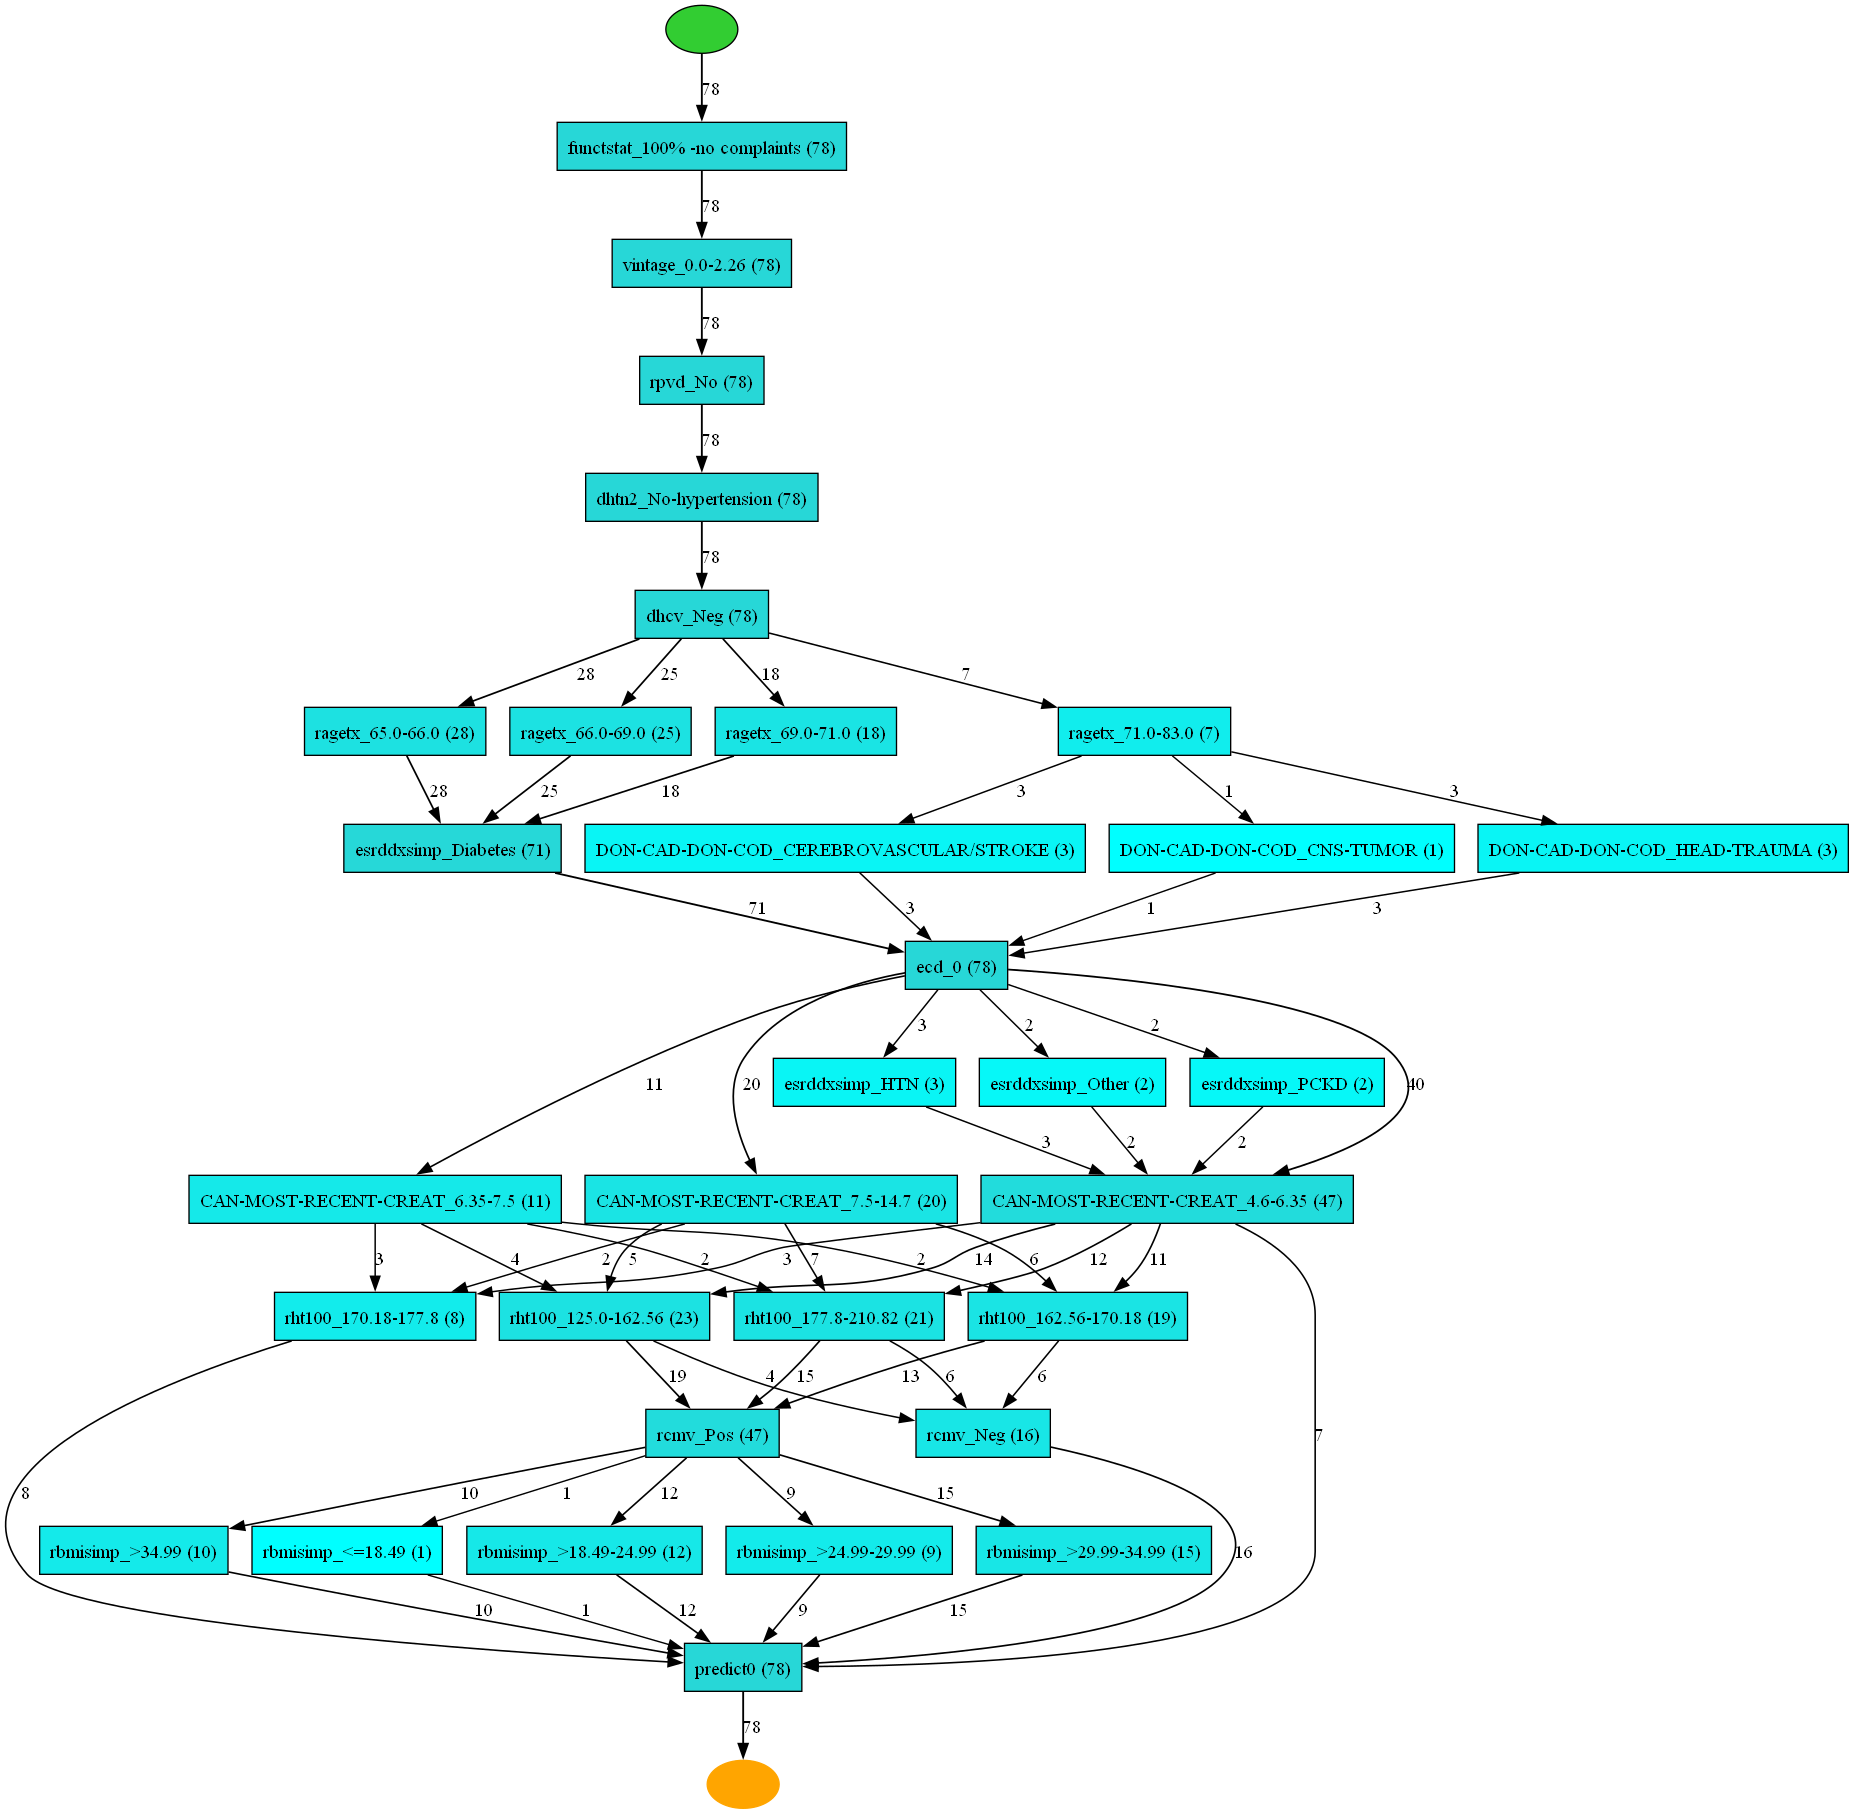

In [39]:
heu_net = heuristics_miner.apply_heu(cluster_holder[3])

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

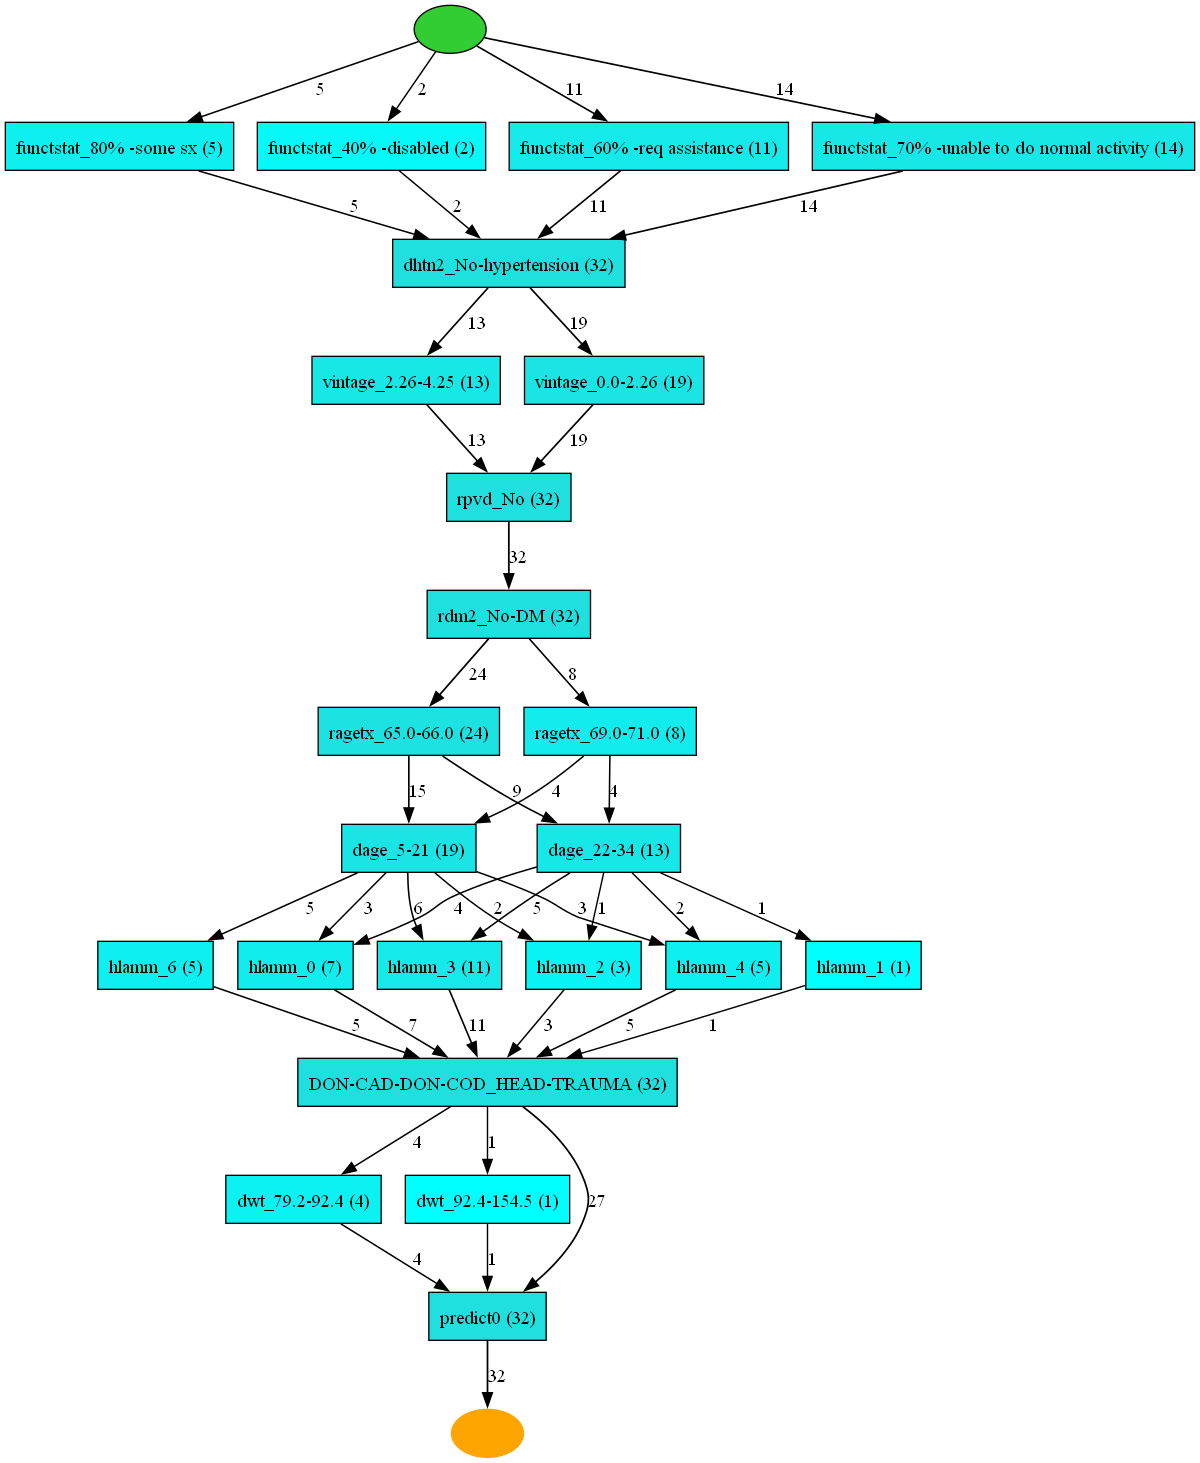

In [40]:
heu_net = heuristics_miner.apply_heu(cluster_holder[4])

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [7]:
from pm4py.objects.conversion.log.converter import apply as log_converter
from pm4py.objects.conversion.log.converter import Variants


In [8]:
log = log_converter(log0, variant=Variants.TO_EVENT_LOG)


In [9]:
from pm4py.statistics.traces.generic.log import case_statistics
variants = case_statistics.get_variant_statistics(log)
print(f"Total cases: {len(log)}, Unique variants: {len(variants)}")


Total cases: 802, Unique variants: 802


In [10]:
from collections import Counter

# Extract all unique activities
activities = sorted({event["concept:name"] for trace in log for event in trace})

# Convert each trace into a vector of activity frequencies
feature_vectors = []
for trace in log:
    counter = Counter([event["concept:name"] for event in trace])
    vector = [counter[act] for act in activities]
    feature_vectors.append(vector)


In [11]:
from pm4py.util import ml_utils
from sklearn.metrics import silhouette_score, davies_bouldin_score

k = 5  # or try a range
kmeans = ml_utils.KMeans(n_clusters=k)
labels = kmeans.fit_predict(feature_vectors)

sil_score = silhouette_score(feature_vectors, labels)
db_score = davies_bouldin_score(feature_vectors, labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Index: {db_score:.3f}")

Silhouette Score: 0.187
Davies–Bouldin Index: 2.013


In [12]:
import matplotlib.pyplot as plt
from pm4py.util import ml_utils
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_scores = []
db_scores = []
k_values = list(range(2, 30))  # Try k from 2 to 10

for k in k_values:
    kmeans = ml_utils.KMeans(n_clusters=k)
    labels = kmeans.fit_predict(feature_vectors)
    
    sil = silhouette_score(feature_vectors, labels)
    dbi = davies_bouldin_score(feature_vectors, labels)

    silhouette_scores.append(sil)
    db_scores.append(dbi)

    # print(f"k={k} → Silhouette: {sil:.3f}, DBI: {dbi:.3f}")


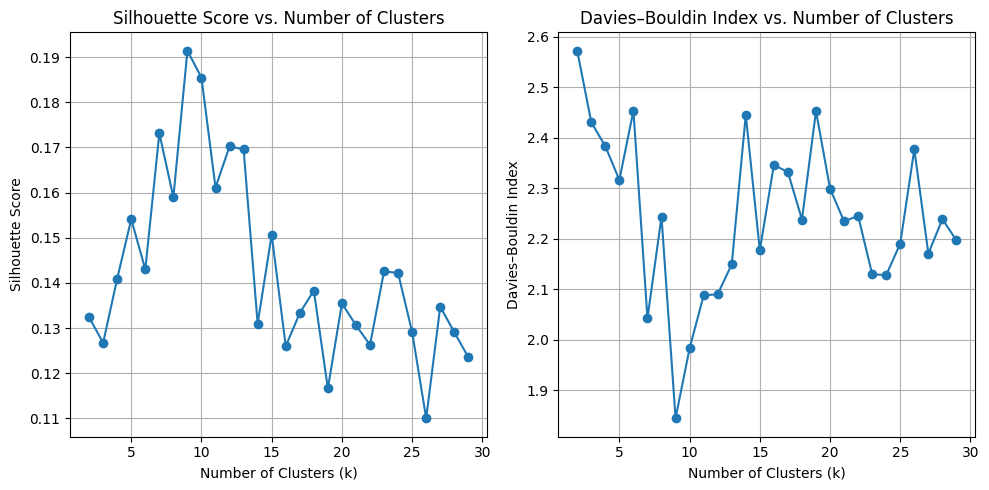

In [13]:
plt.figure(figsize=(10, 5))

# Silhouette Score Plot
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

# Davies–Bouldin Index Plot
plt.subplot(1, 2, 2)
plt.plot(k_values, db_scores, marker='o')
plt.title("Davies–Bouldin Index vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies–Bouldin Index")
plt.grid(True)

plt.tight_layout()
plt.show()
